## 0 - IMPORTAÇAO DAS BIBLIOTECAS

In [1]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# A biblioteca Sklearn mudou o nome e passou a se chamar scikit-learn -> pip install scikit-learn

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from IPython.core.display import HTML
from IPython.display import Image
import datetime

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Logo abaixo fazendo a junção com o Merge

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )


# 0.1 - Helper Functions

In [128]:
def cross_validation ( x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('\nKFold Number: {}'.format( k ) )
        
        # Inicio e fim da validacao das datas
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrando o dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date)]

        # Treino e Validação do Dataset
        # Treino
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validacao
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']


        # Modelo
        m = model.fit(xtraining, ytraining)

        # Predicao
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
        #print(lr_result)
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round(np.mean( mae_list ) ,2).astype( str ) + ' + / - ' + np.round(np.std(mae_list),2).astype( str ),
                          'MAPE CV': np.round(np.mean( mape_list ) ,2).astype( str ) + ' + / - ' + np.round(np.std(mape_list),2).astype( str ),
                          'RMSE CV': np.round(np.mean( rmse_list ) ,2).astype( str ) + ' + / - ' + np.round(np.std(rmse_list),2).astype( str )}, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

## 1 - Copia dos Dados

In [4]:
## Copia dos dados

df1 = df_raw.copy()

In [5]:
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
## Aqui pode ler o dataframe com o comando sample para vir qualquer numero aleatorio 

df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
147028,964,7,2015-03-22,0,0,0,0,0,0,a,a,270.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
854611,192,7,2013-05-26,0,0,0,0,0,0,d,c,2770.0,3.0,2008.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"
694306,447,4,2013-10-17,3732,494,1,0,0,1,a,c,1510.0,9.0,2013.0,0,NaN,NaN,NaN
767347,1013,2,2013-08-13,4746,464,1,1,0,1,a,a,630.0,2.0,2015.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
540338,349,2,2014-03-04,8607,865,1,1,0,0,c,c,1490.0,4.0,2009.0,0,NaN,NaN,NaN


## 1.1 - Renomear as Colunas

In [7]:
## Exibe os nomes das colunas

df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Dimensao do Dataframe

In [10]:
print ('O numero total de linhas são: {}'.format(df1.shape[0]))
print ('O numero total de colunas são: {}'.format(df1.shape[1]))

O numero total de linhas são: 1017209
O numero total de colunas são: 18


## 1.3 - Tipos de dados

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check de NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Tratamento dos NA ou Seja ( Não Aplicada) - Dados faltantes

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan (x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week               
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan (x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan (x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval                  
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1) 


In [15]:
df1.sample(5).T

,724407,704278,904218,233222,73375
store,443,384,739,188,901
day_of_week,5,2,5,6,3
date,2013-09-20 00:00:00,2013-10-08 00:00:00,2013-04-12 00:00:00,2015-01-03 00:00:00,2015-05-27 00:00:00
sales,4363,10690,10707,4075,6497
customers,493,1161,783,358,614
open,1,1,1,1,1
promo,0,1,1,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,d,d,a


## 1.6 - Change Types

In [16]:
## Mudando algumas colunas para inteiro, pois estavam como float

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype (int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype (int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype (int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype (int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 - Estatistica descritiva

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'int32', 'float64', 'datetime64[ns]'])

In [18]:
# Variaveis numericas
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
873479,105,4,0,0,0,0,0,6190.0,5,2013,1,23,2013,0
65869,85,2,8099,1046,1,1,0,1870.0,10,2011,0,23,2015,0


In [19]:
# Variaveis Categoricas
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
88552,0,c,c,0,May
941125,0,d,c,"Mar,Jun,Sept,Dec",Mar


## 1.7.1 - Atributos numericos

In [20]:
# Central e tendencia - media e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T

# Dispersão - Desvio padrão - STD, maximo, minimo, range (valor entre o minimo e maximo), Skew e Kurtose
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

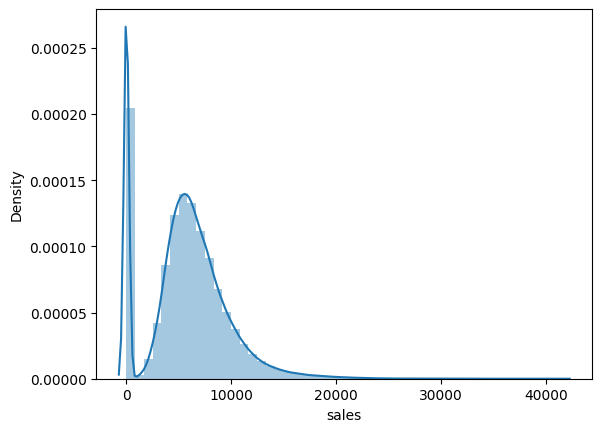

In [21]:
sns.distplot(df1['sales'])

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\3391210532.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance']);


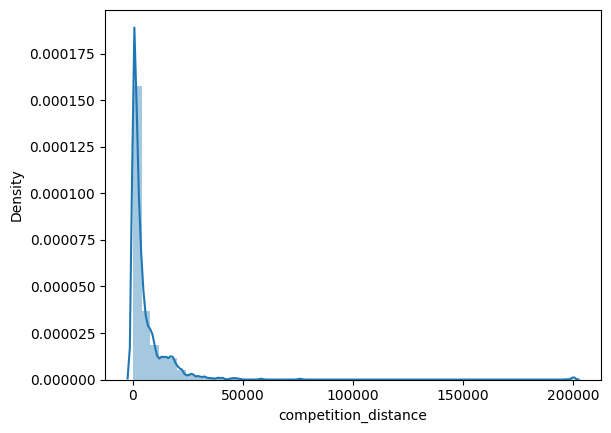

In [22]:
sns.distplot(df1['competition_distance']);

## 1.7.2 - Dados Categoricos

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

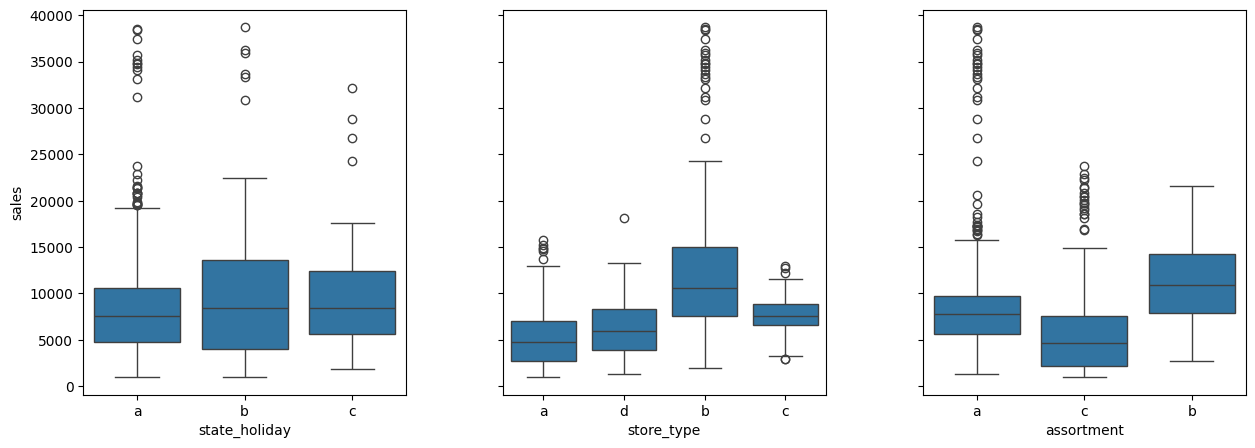

In [24]:
# Crie uma figura com subplots e defina o tamanho da figura e o espaçamento horizontal
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.subplots_adjust(wspace=0.3)  # Ajuste o espaçamento horizontal

# Seu código para os subplots
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])  # Usando o primeiro subplot
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])  # Usando o segundo subplot
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])  # Usando o terceiro subplot

plt.show()

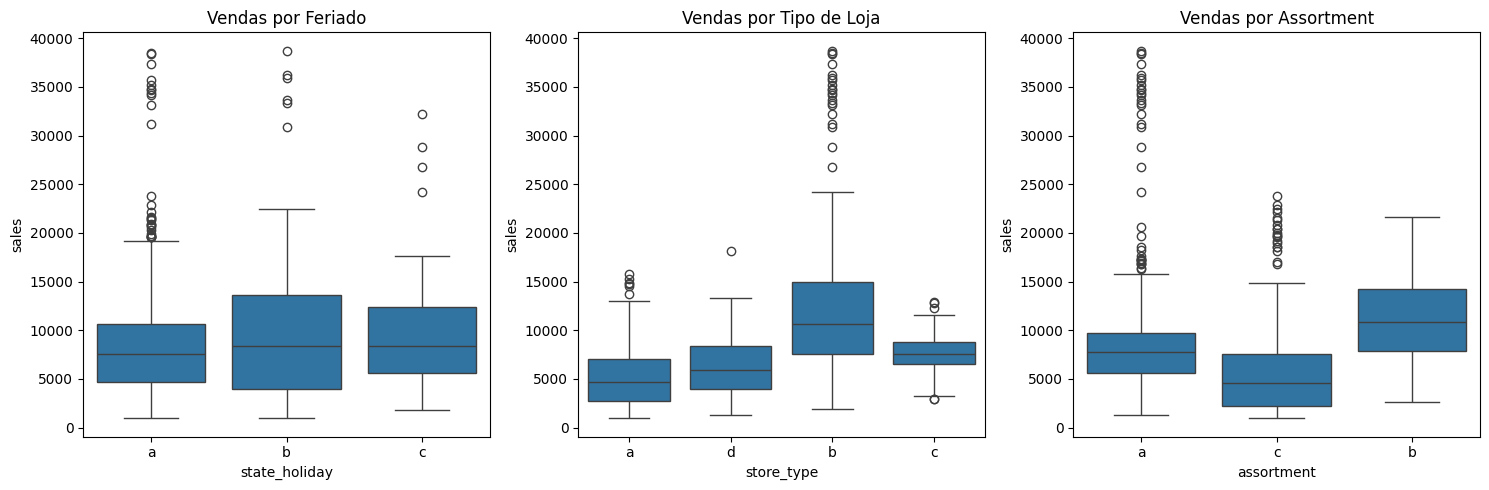

In [25]:
# Filtrar os dados
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Criar uma figura com 1 linha e 3 colunas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico 1
sns.boxplot(x='state_holiday', y='sales', data=aux1, ax=axes[0])
axes[0].set_title('Vendas por Feriado')

# Gráfico 2
sns.boxplot(x='store_type', y='sales', data=aux1, ax=axes[1])
axes[1].set_title('Vendas por Tipo de Loja')

# Gráfico 3
sns.boxplot(x='assortment', y='sales', data=aux1, ax=axes[2])
axes[2].set_title('Vendas por Assortment')

# Ajustar o espaçamento entre os gráficos
plt.tight_layout()

# Exibir a figura
plt.show()

In [26]:

# Suponha que você já tem seus dados em 'df1' e 'aux1' foi criado como indicado na pergunta

# Ajuste o tamanho da figura
plt.figure(figsize=(12, 2))

# Crie os subplots com um espaçamento adequado
#plt.subplot(1, 3, 1)
#sns.boxplot(x='state_holiday', y='sales', data=aux1)
#plt.title('State Holiday')

#plt.subplot(1, 3, 2)
#sns.boxplot(x='store_type', y='sales', data=aux1)
#plt.title('Store Type')

#plt.subplot(1, 3, 3)
#sns.boxplot(x='assortment', y='sales', data=aux1)
#plt.title('Assortment')

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()

# Exiba os gráficos interativamente usando Plotly


fig = px.box(aux1, x='state_holiday', y='sales')
fig.update_layout(title='State Holiday')
fig.show()

fig = px.box(aux1, x='store_type', y='sales')
fig.update_layout(title='Store Type')
fig.show()

fig = px.box(aux1, x='assortment', y='sales')
fig.update_layout(title='Assortment')
fig.show()

<Figure size 1200x200 with 0 Axes>

## 2.0 - Feature Engineering


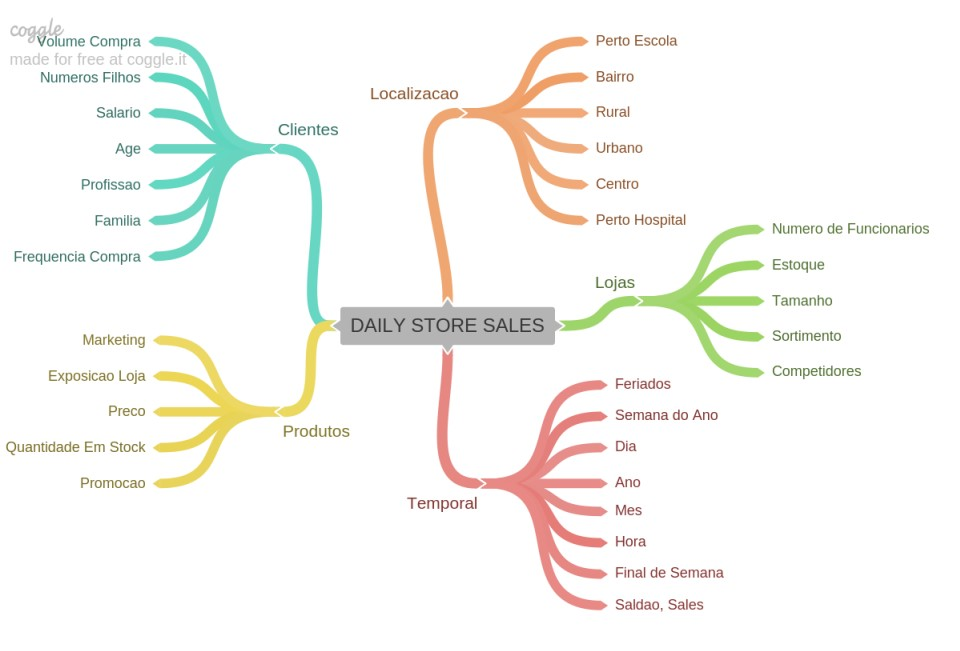

In [27]:
Image('img/mapa_mental.jpg')

In [28]:
df2 = df1.copy()

In [29]:
# - Year - Ano

df2['year'] = df2['date'].dt.year

# - Month - Mes

df2['month'] = df2['date'].dt.month

# - Day - Dia

df2['day'] = df2['date'].dt.day

# - week_of_year - Semana do ano

df2['week_of_year'] = df2['date'].dt.strftime('%U') # Tive que mexer nessa função para poder retornar as semanas dos anos 
df2['week_of_year'] = df2['week_of_year'].astype (int)

# - year week - Ano da semana

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# - Competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype(int)

# - promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# - Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# - State holiday - feriados
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')


In [30]:
df2.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 - Filtragem de variavel

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,30,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,30,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,30,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,30,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,30,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 - Filtragem das linhas

In [33]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [34]:
# - Limpando as colunas que não fazem relevancia no projeto

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [35]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 Analise Exploratoria de Dados

In [36]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Variaveis de Resposta

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\1473926699.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

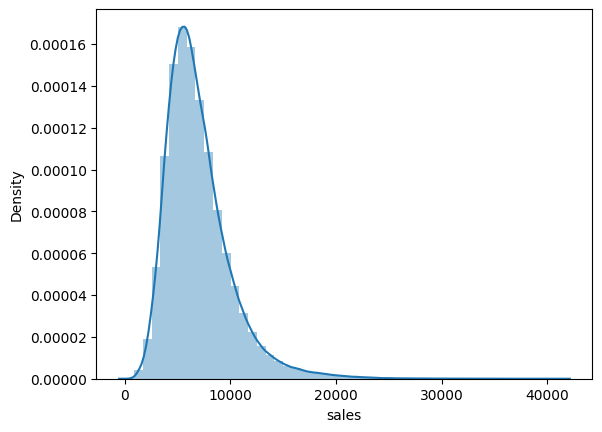

In [37]:
sns.distplot(df4['sales'])

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\167578569.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='sales', ylabel='Density'>

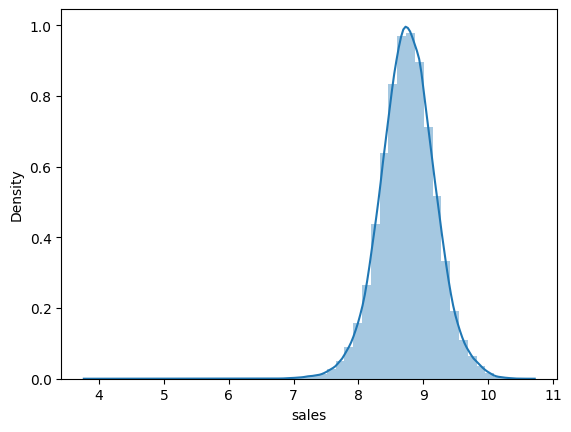

In [38]:
# Aqui utilizando o log1p para chegar mais proximo de uma variavel normal

sns.distplot(np.log1p(df4['sales']))

### 4.1.2 Variaveis Numericas

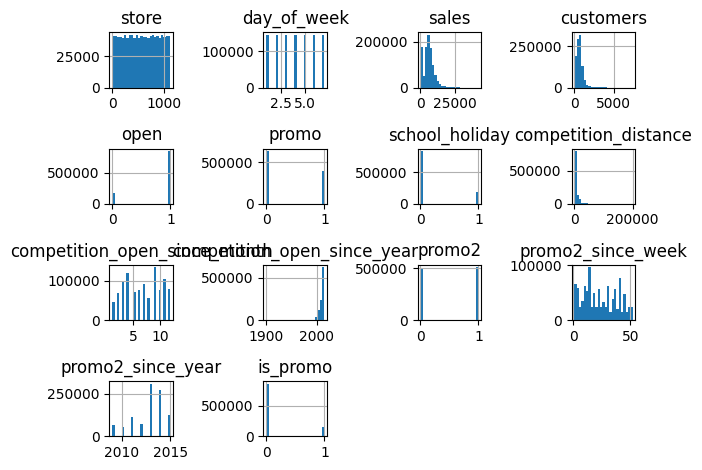

In [39]:
num_attributes.hist(bins=25);

# Ajustar espaçamento entre os subplots
plt.tight_layout()

# Mostrar os gráficos
plt.show()

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\2554253099.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




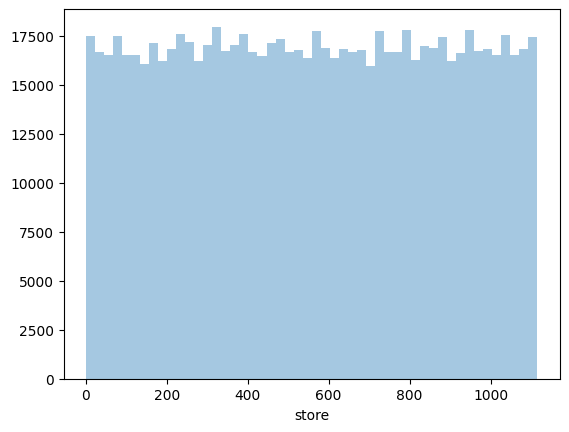

In [40]:
sns.distplot(df4['store'],kde=False); # com o kde=False ele não tras a curva

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\2226213634.py:11: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\2226213634.py:14: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\2226213634.py:15: UserWarning:



`distplot`

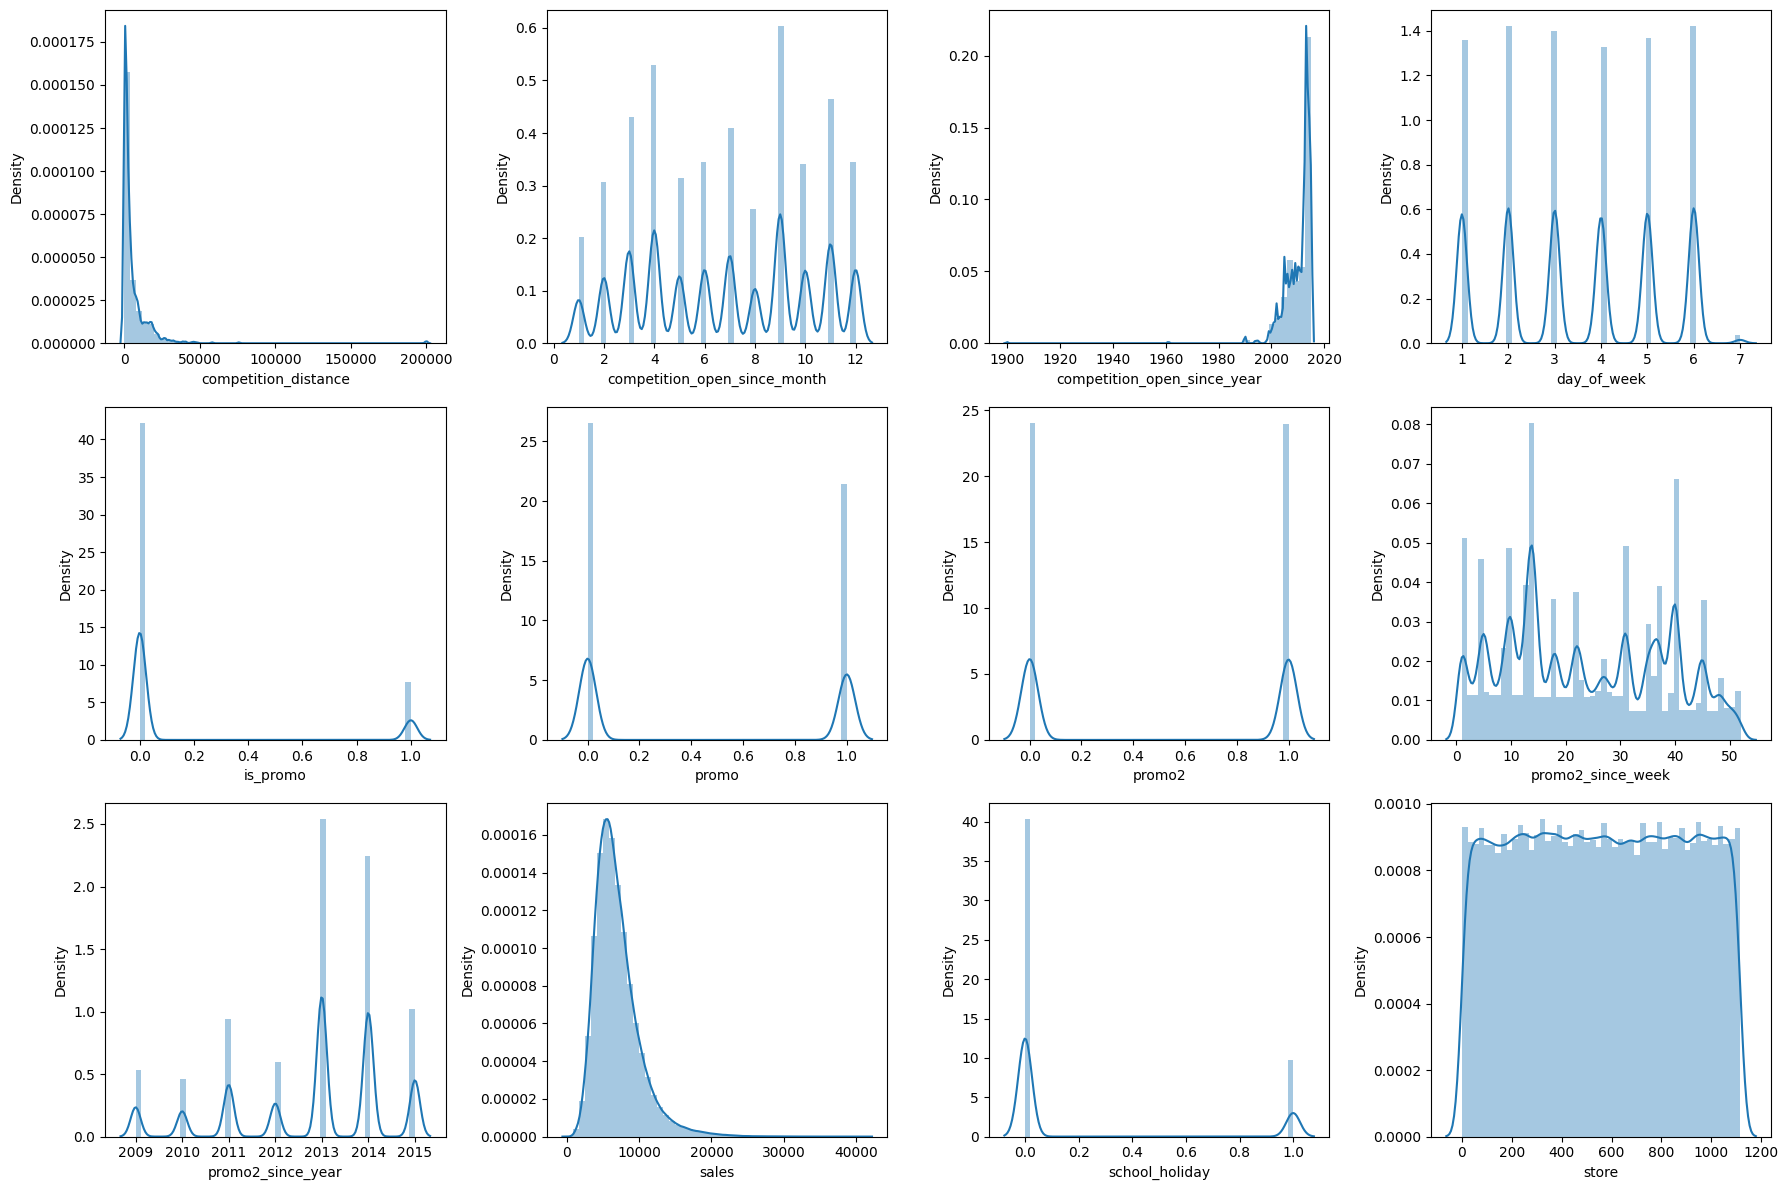

In [41]:
# Suponha que você tenha um DataFrame chamado df4 com os dados

# Crie uma figura com subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12));


# Colunas dropadas
#customers', 'open', 'promo_interval', 'month_ma

# Agora, você pode usar sns.distplot para desenhar cada gráfico em um subplot específico
sns.distplot(df4['competition_distance'], ax=axes[0, 0]);
#axes[0, 0].set_title('Distribuição da loja')

sns.distplot(df4['competition_open_since_month'], ax=axes[0, 1]);
sns.distplot(df4['competition_open_since_year'], ax=axes[0, 2]);
sns.distplot(df4['day_of_week'], ax=axes[0, 3]);
sns.distplot(df4['is_promo'], ax=axes[1, 0]);
sns.distplot(df4['promo'], ax=axes[1, 1]);
sns.distplot(df4['promo2'], ax=axes[1, 2]);
sns.distplot(df4['promo2_since_week'], ax=axes[1, 3]);
sns.distplot(df4['promo2_since_year'], ax=axes[2, 0]);
sns.distplot(df4['sales'], ax=axes[2, 1]);
sns.distplot(df4['school_holiday'], ax=axes[2, 2]);
sns.distplot(df4['store'], ax=axes[2, 3]);

# Vamos supor que você tenha mais dados para outros gráficos
# Por exemplo:
# sns.scatterplot(x=df4['coluna1'], y=df4['coluna2'], ax=axes[0, 1])
# axes[0, 1].set_title('Gráfico de dispersão')

# Você pode adicionar mais gráficos conforme necessário

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout();

# Exiba a figura
plt.show();

### 4.1.3 Variaveis Categoricas

In [42]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [43]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    Easter_holiday
241126         Christmas
Name: state_holiday, dtype: object

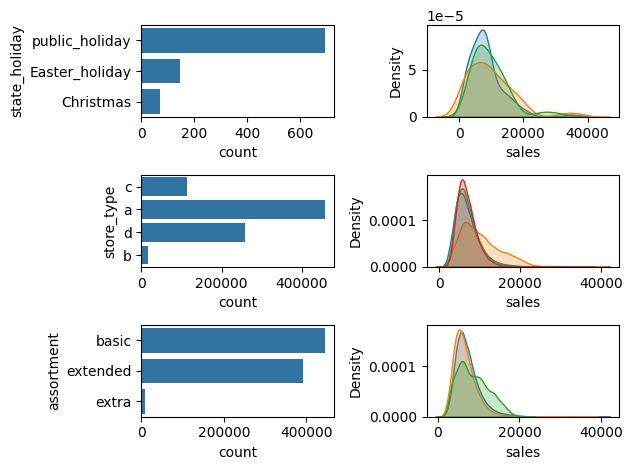

In [44]:
# State Holidays

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Easter_holiday']['sales'], label='Easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', fill=True)

# Store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)


# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)


# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()


## 4.2 Analise Bivariada

### H1 - As lojas que tem um mix mais variado de produtos deveriam vender mais ?
#### FALSO --> Resposta lojas que tem um maior mix na verdade são as que vendem menos

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\560123680.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




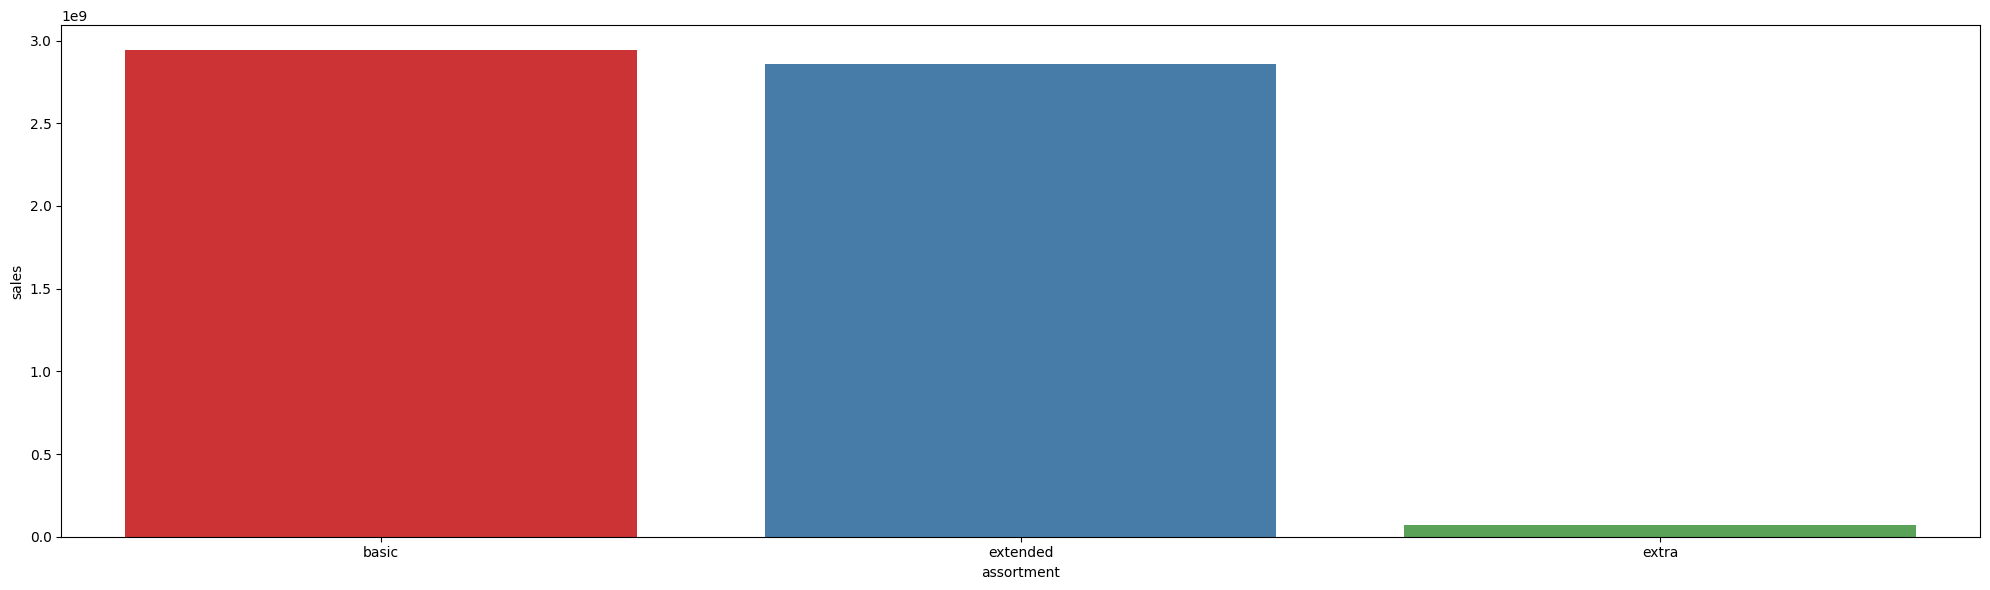

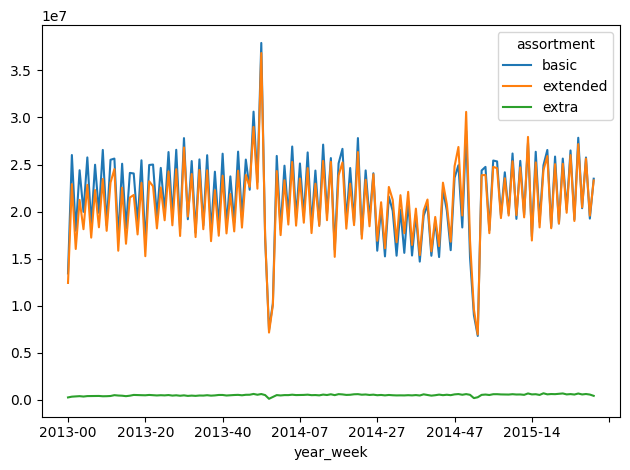

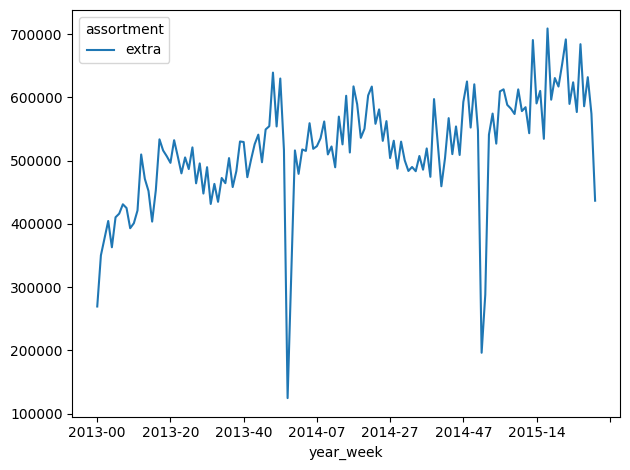

In [45]:
# As lojas que tem um mix mais variado de produtos deveriam vender mais ?

# - FALSO --> Resposta lojas que tem um maior mix na verdade são as que vendem menos

# Defina sua paleta de cores personalizada como uma lista de cores

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(20, 6))
sns.barplot(x='assortment', y='sales', data=aux1, palette='Set1');

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### H2 - Lojas com competidores mais proximos deveriam vender menos

#### FALSA - Lojas com COMPETIDORES mais proximos vendem MAIS

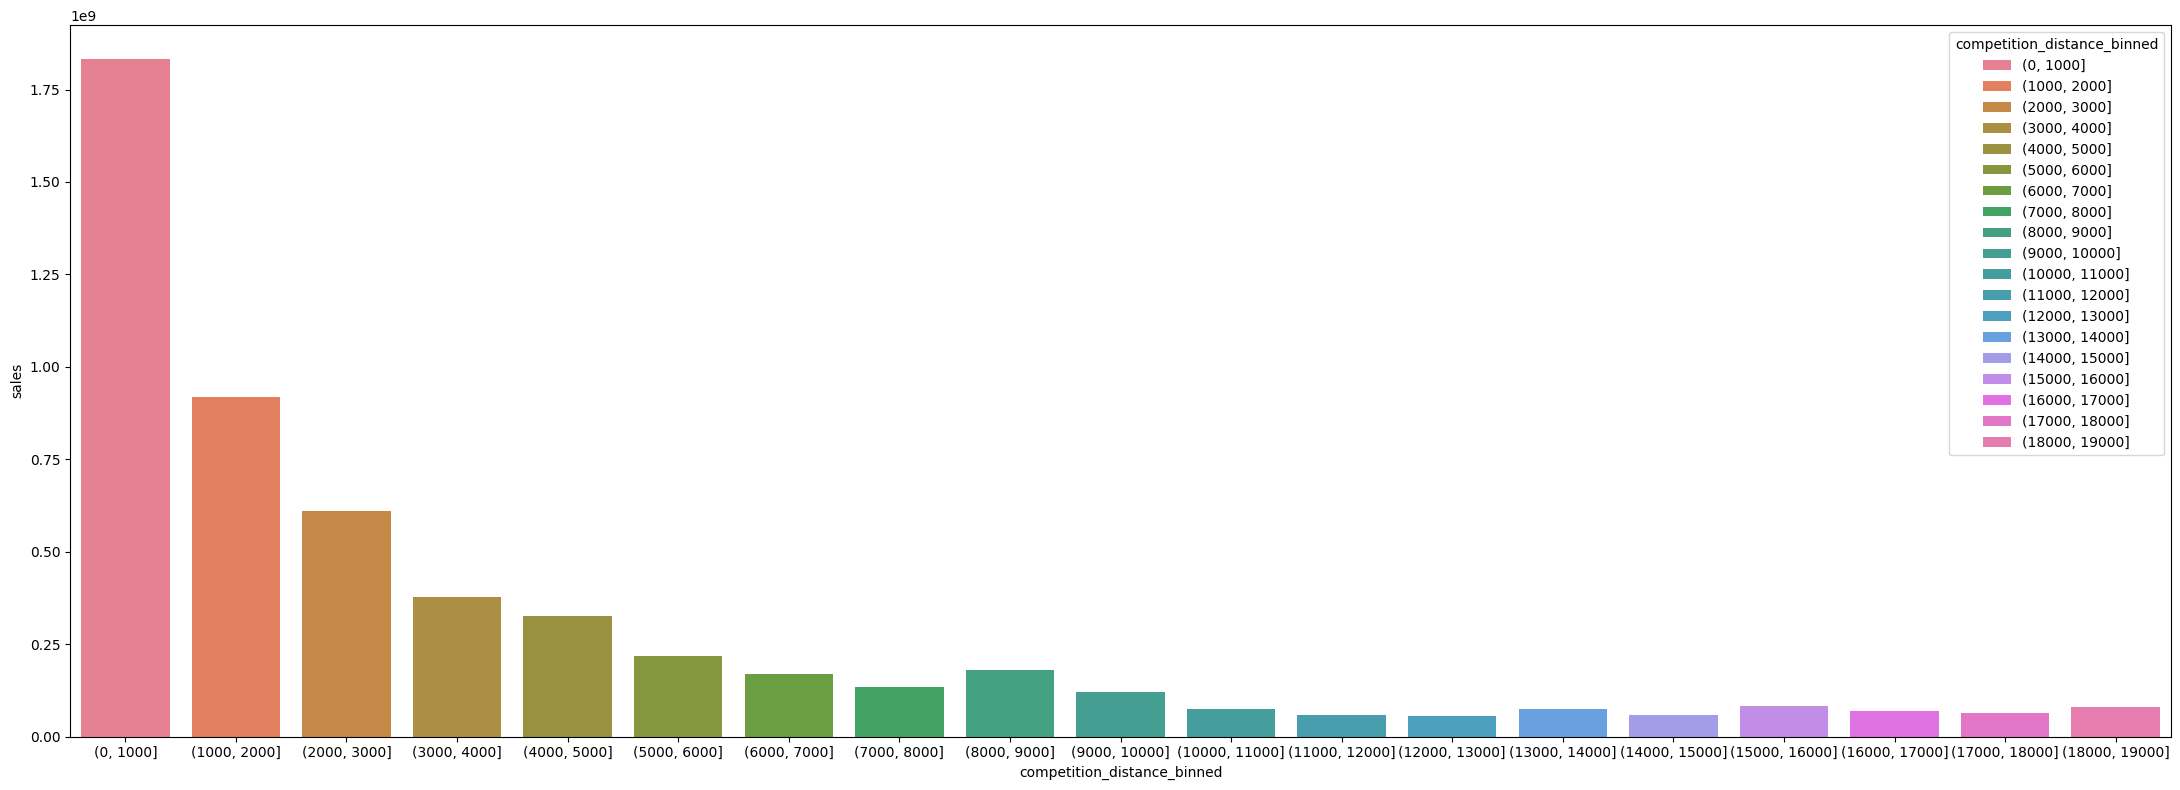

In [46]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


plt.figure(figsize=(22, 8))
#sns.barplot(x='competition_distance_binned', y='sales', data=aux2, palette='Set1');
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned');
# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

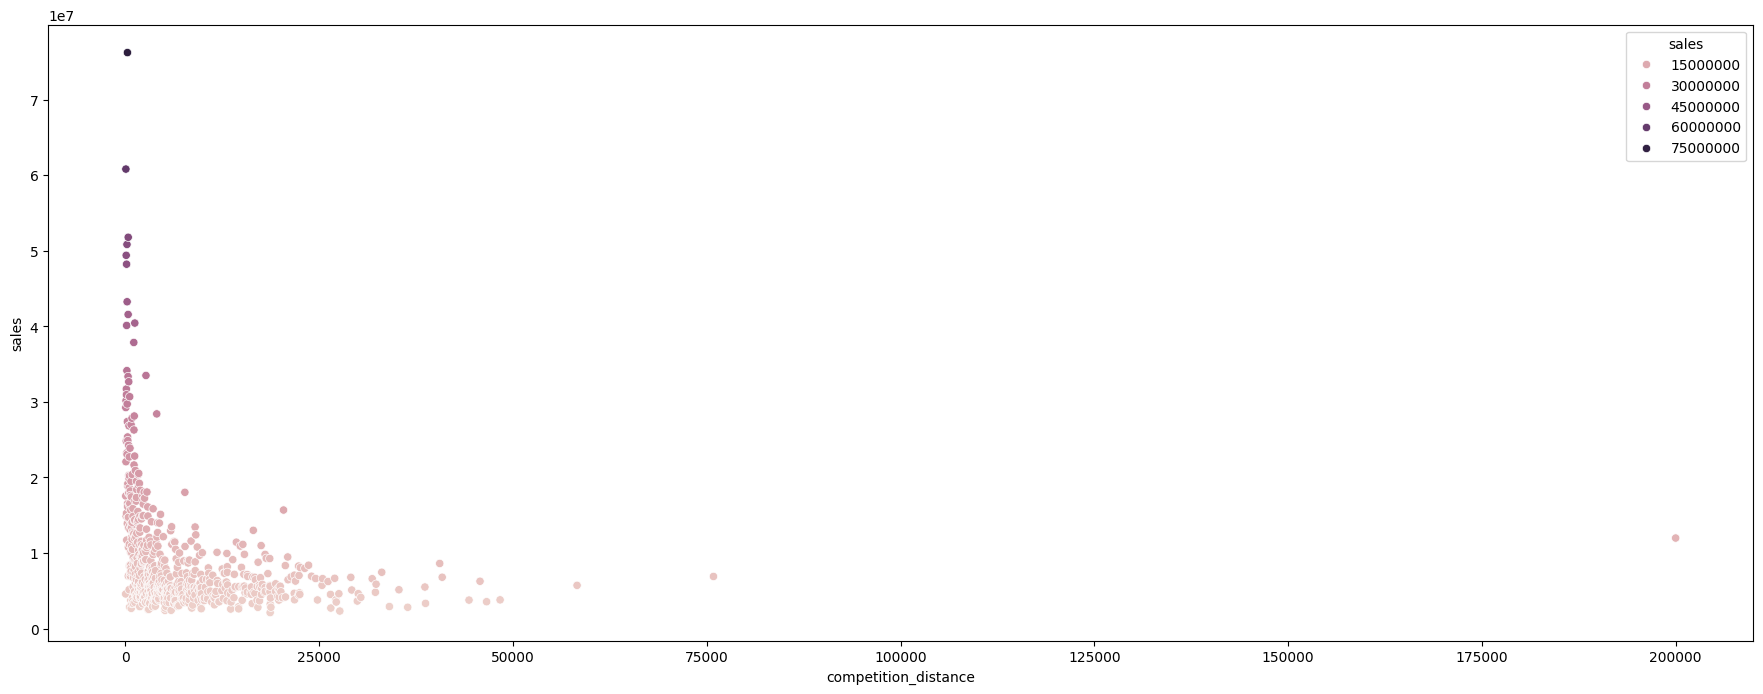

In [47]:
# Fazendo graficos com o scatterplot

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.figure(figsize=(22, 8))
sns.scatterplot(x='competition_distance', y='sales', data=aux1, hue='sales');


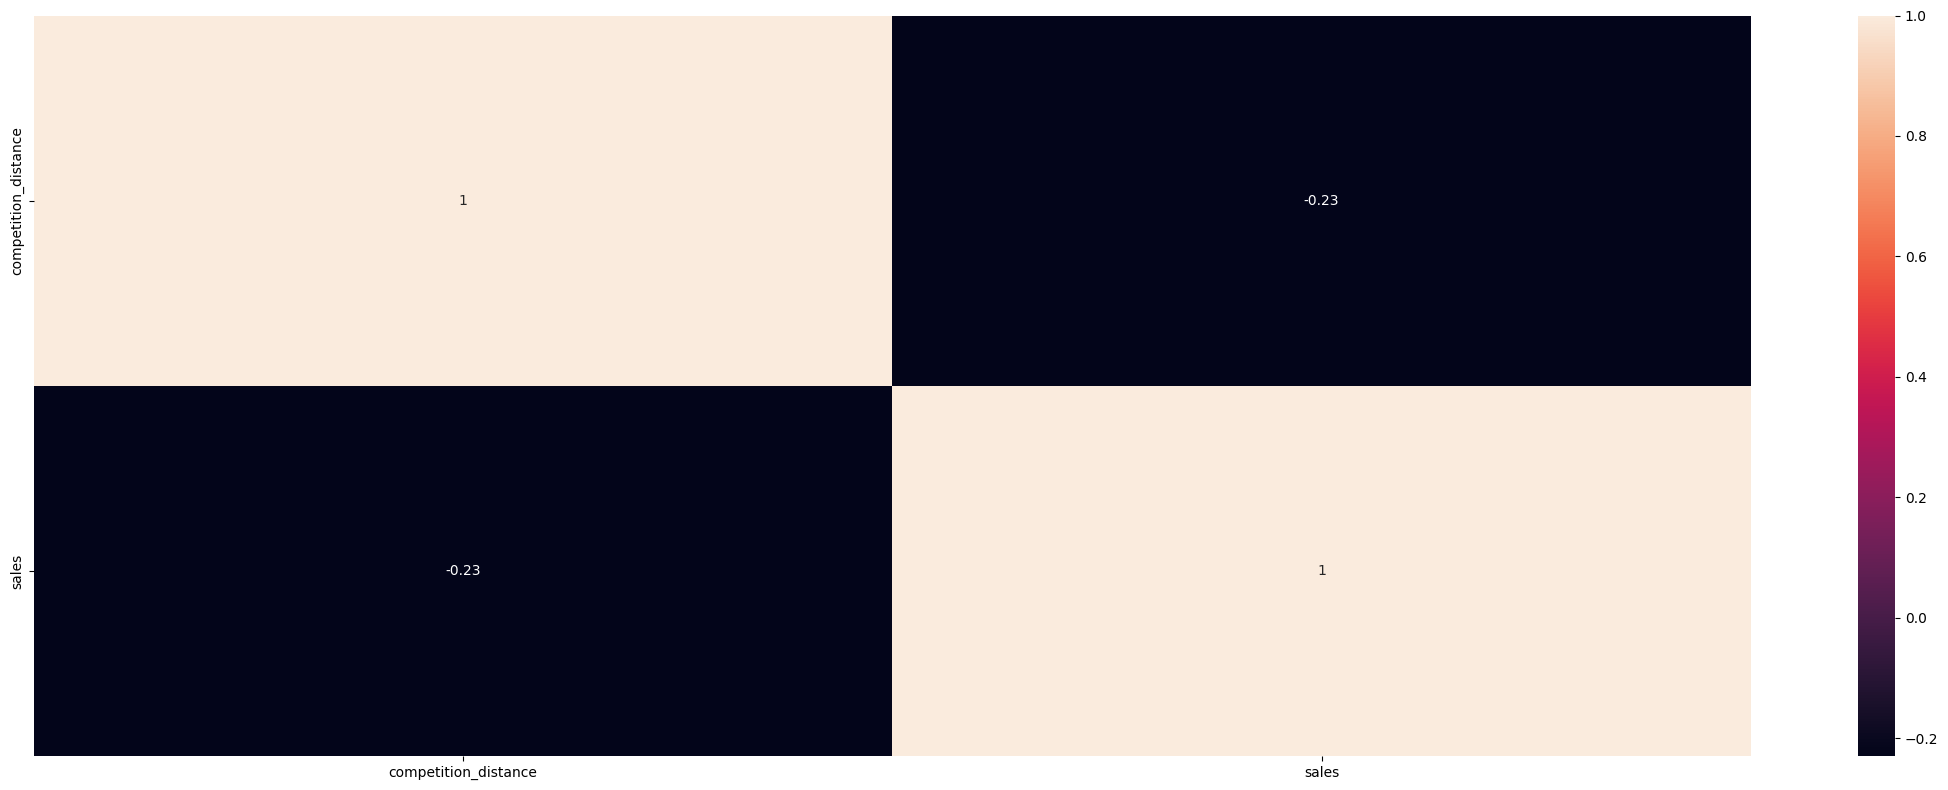

In [48]:
plt.figure(figsize=(22, 8))

sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura
plt.show()

### H3 Lojas com competidores à mais tempo deveriam vender mais

#### É FALSO - > Lojas com COMPETIDORES à mais tempo VENDEM MENOS

In [49]:
aux1 = df4[['competition_time_month', 'sales']].groupby(['competition_time_month']).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]

plt.figure(figsize=(22, 8))

#sns.barplot(x='competition_open_since_month', y='sales', data=aux1, hue='competition_open_since_month' )

fig = px.bar(aux2, x='competition_time_month', y='sales', color='competition_time_month')

# Atualize o layout do gráfico para evitar sobreposição de rótulos
fig.update_layout(
    xaxis=dict(tickmode='linear'),
    xaxis_title='Competicap por Mes',
    yaxis_title='Sales',
    title='Vendas por Mês de Abertura da Concorrência'
)

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura

fig.show()

<Figure size 2200x800 with 0 Axes>

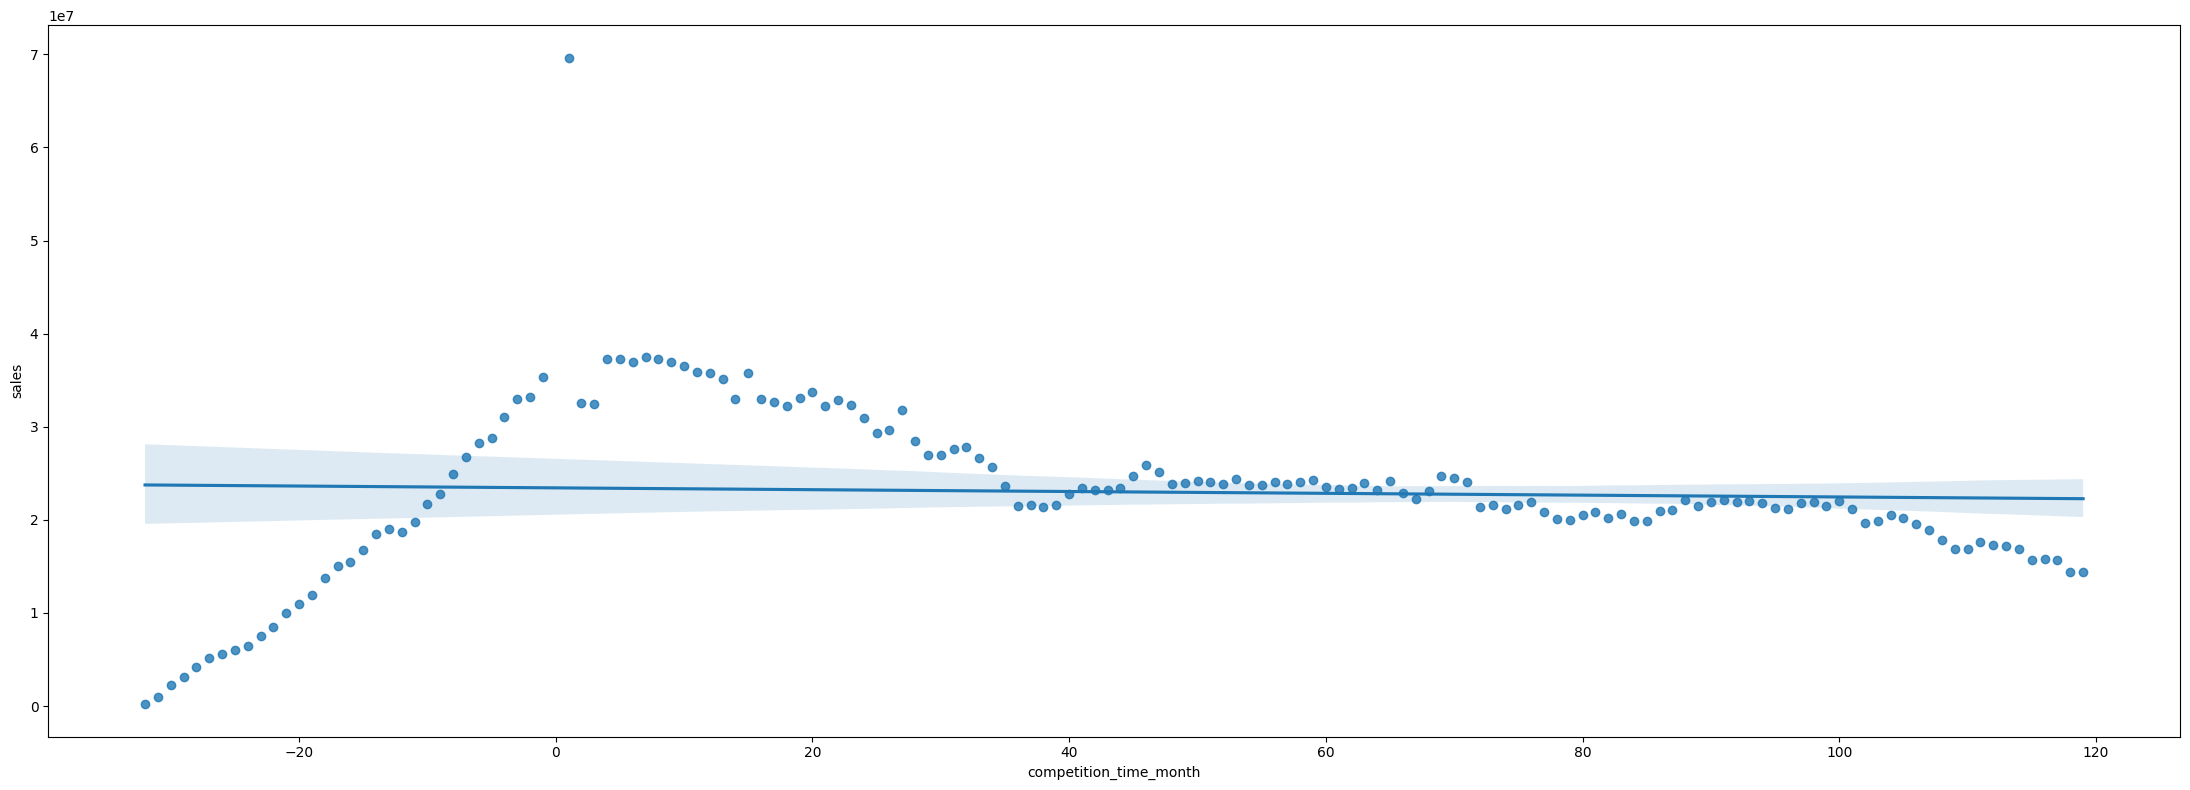

In [50]:
plt.figure(figsize=(22, 8))

sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.tight_layout()

# Exiba a figura

plt.show()

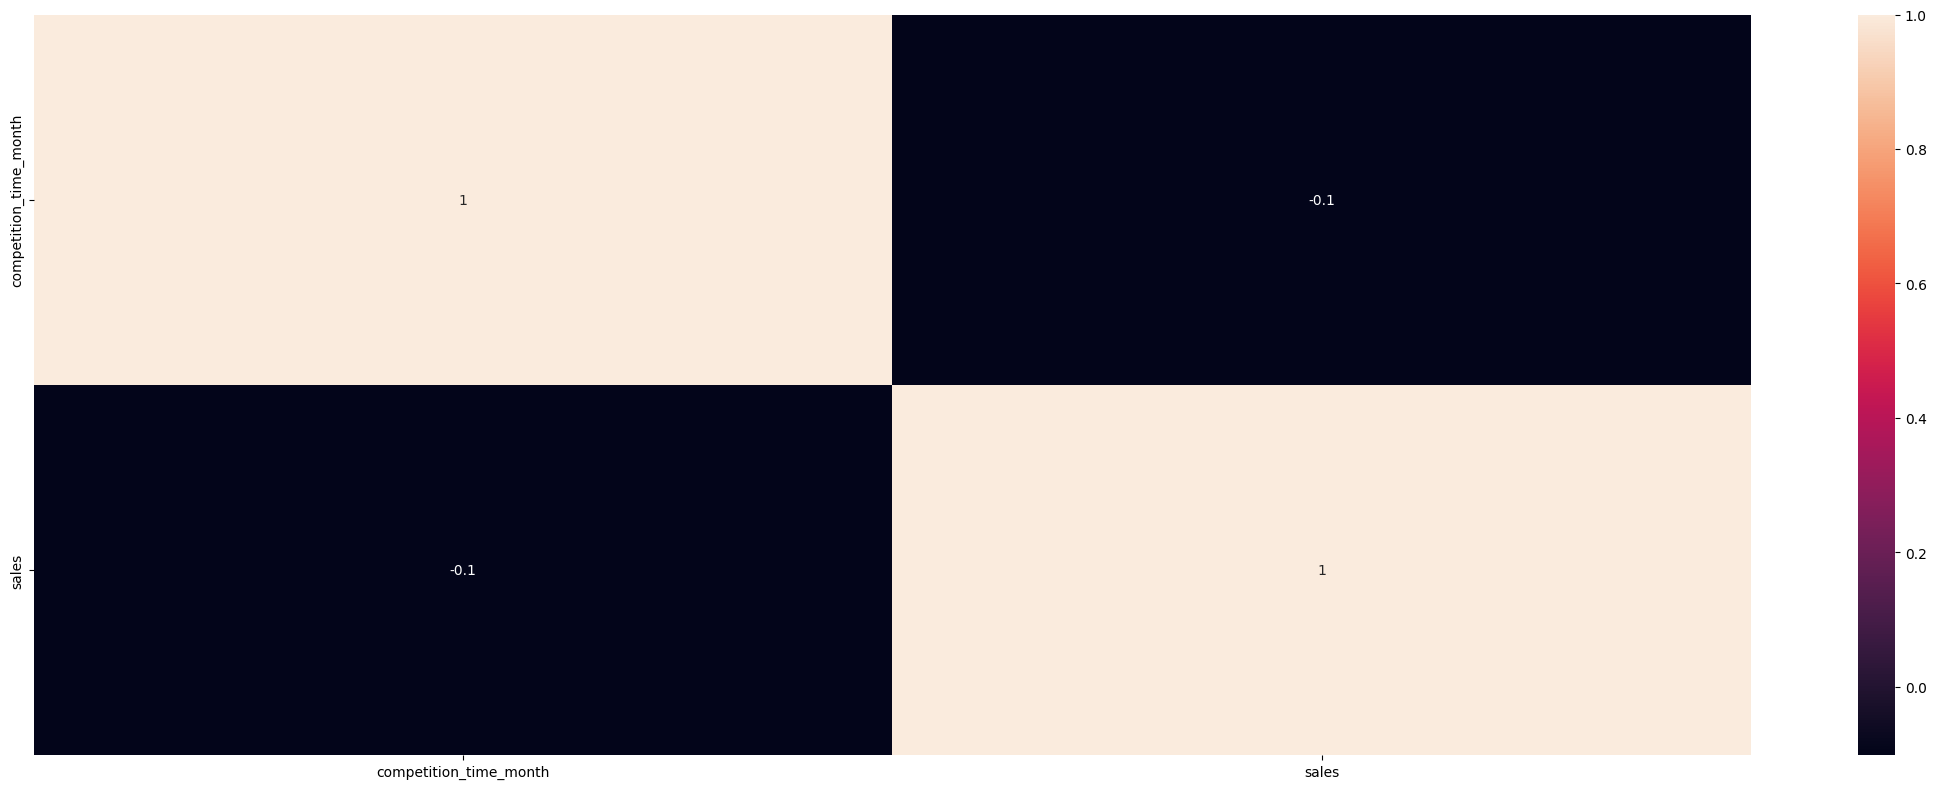

In [51]:
plt.figure(figsize=(22, 8))

sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Ajuste o layout para evitar sobreposição de rótulos

plt.tight_layout()

# Exiba a figura
plt.show()

### H4 Lojas com promoções ativas por mais tempo deveriam vender mais

#### **FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promoção

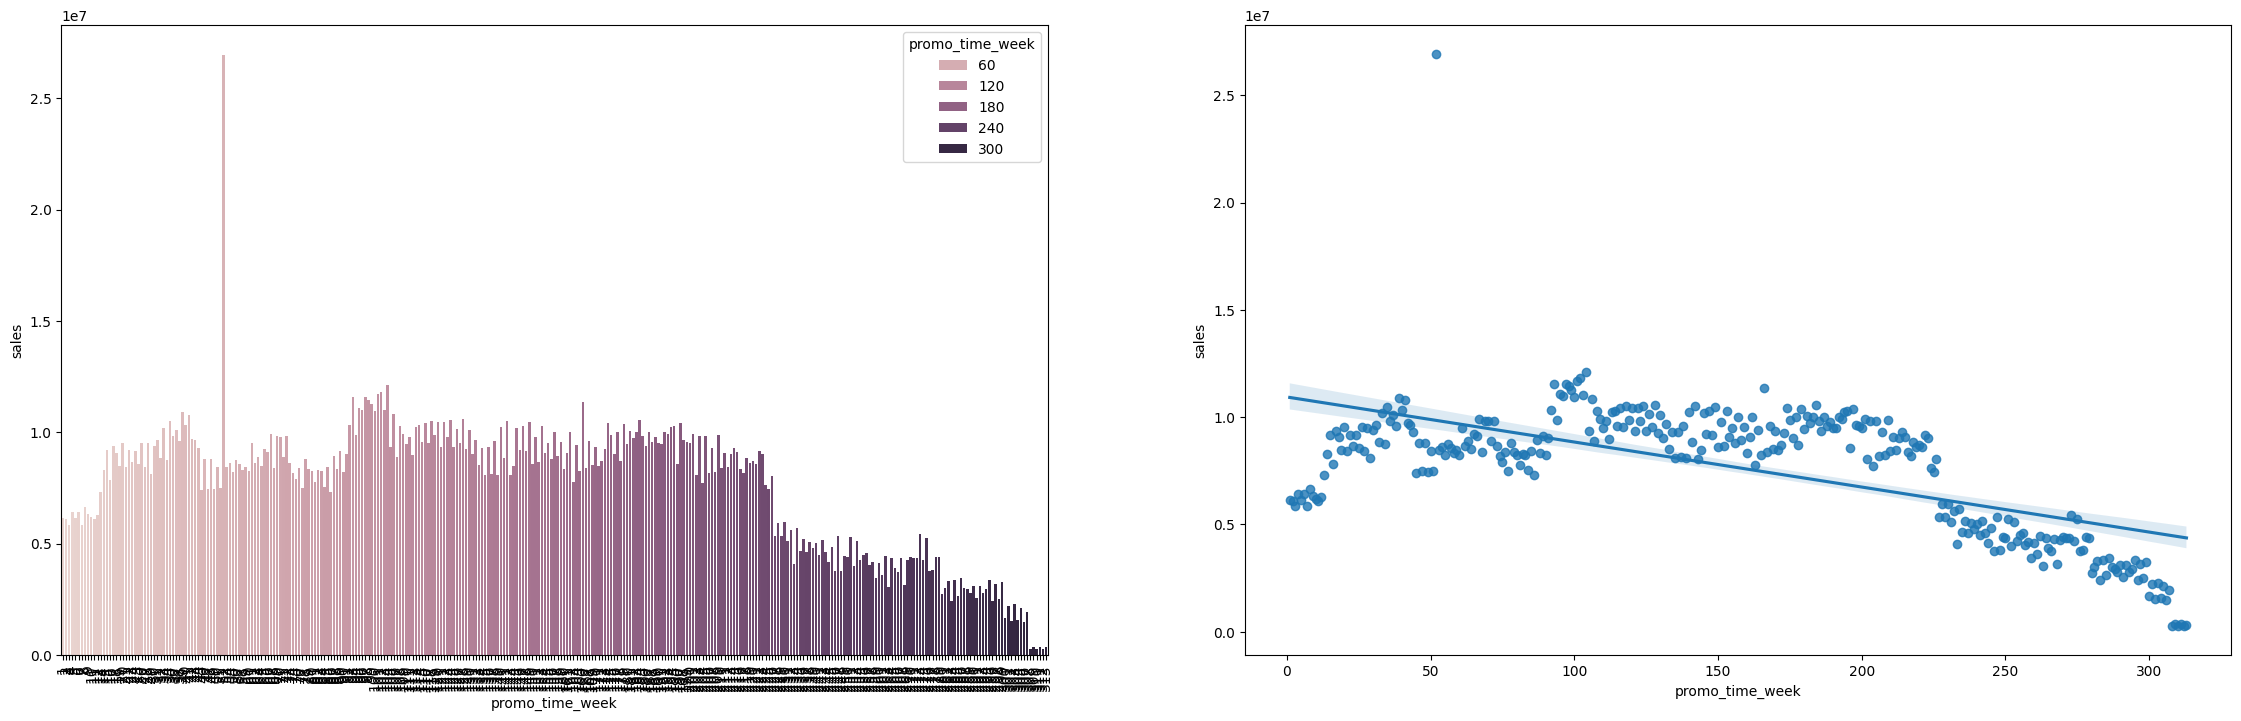

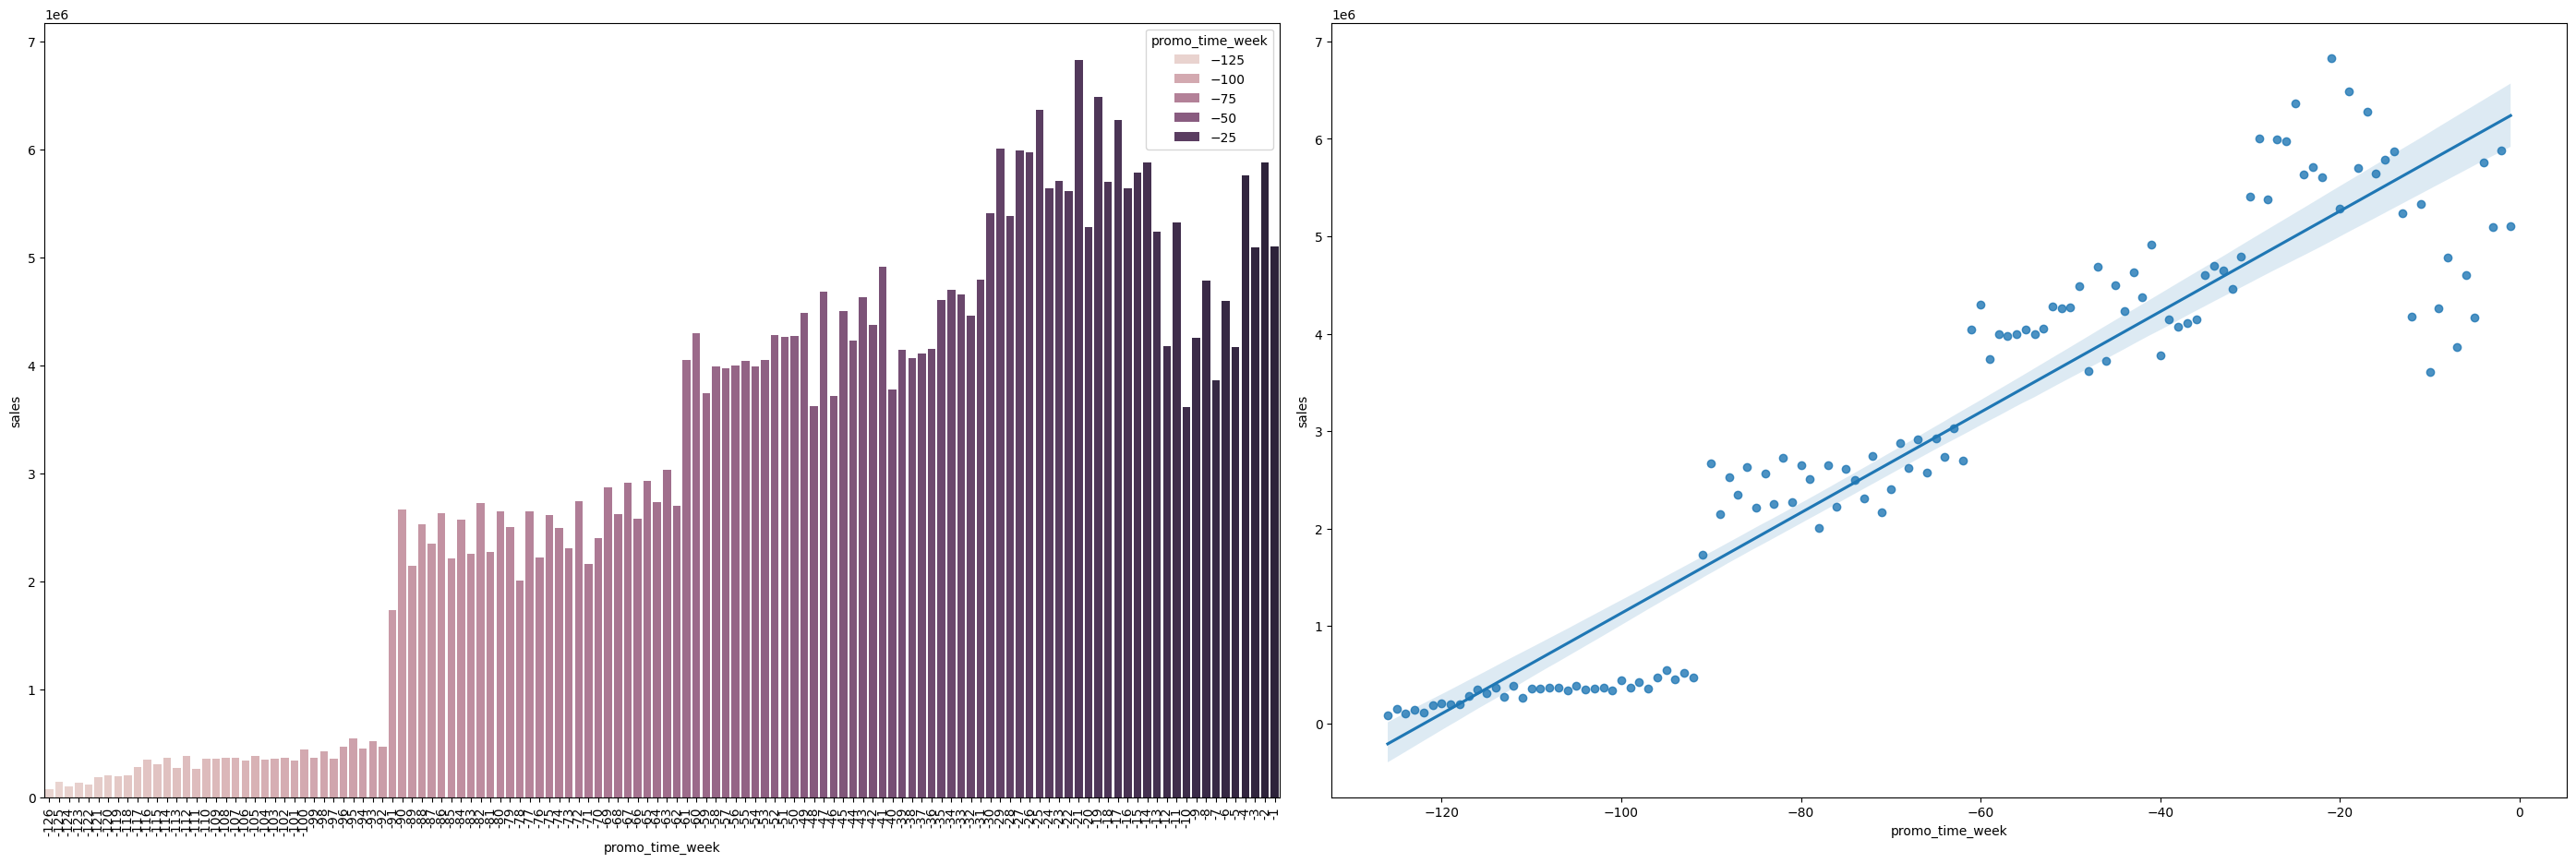

In [52]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(28, 18))
plt.subplot(2,2,1)

aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2, hue='promo_time_week')
plt.xticks(rotation=90);


plt.subplot(2,2,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.figure(figsize=(28, 18))
plt.subplot(2,2,3)

aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3, hue='promo_time_week')
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3)

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

<Axes: >

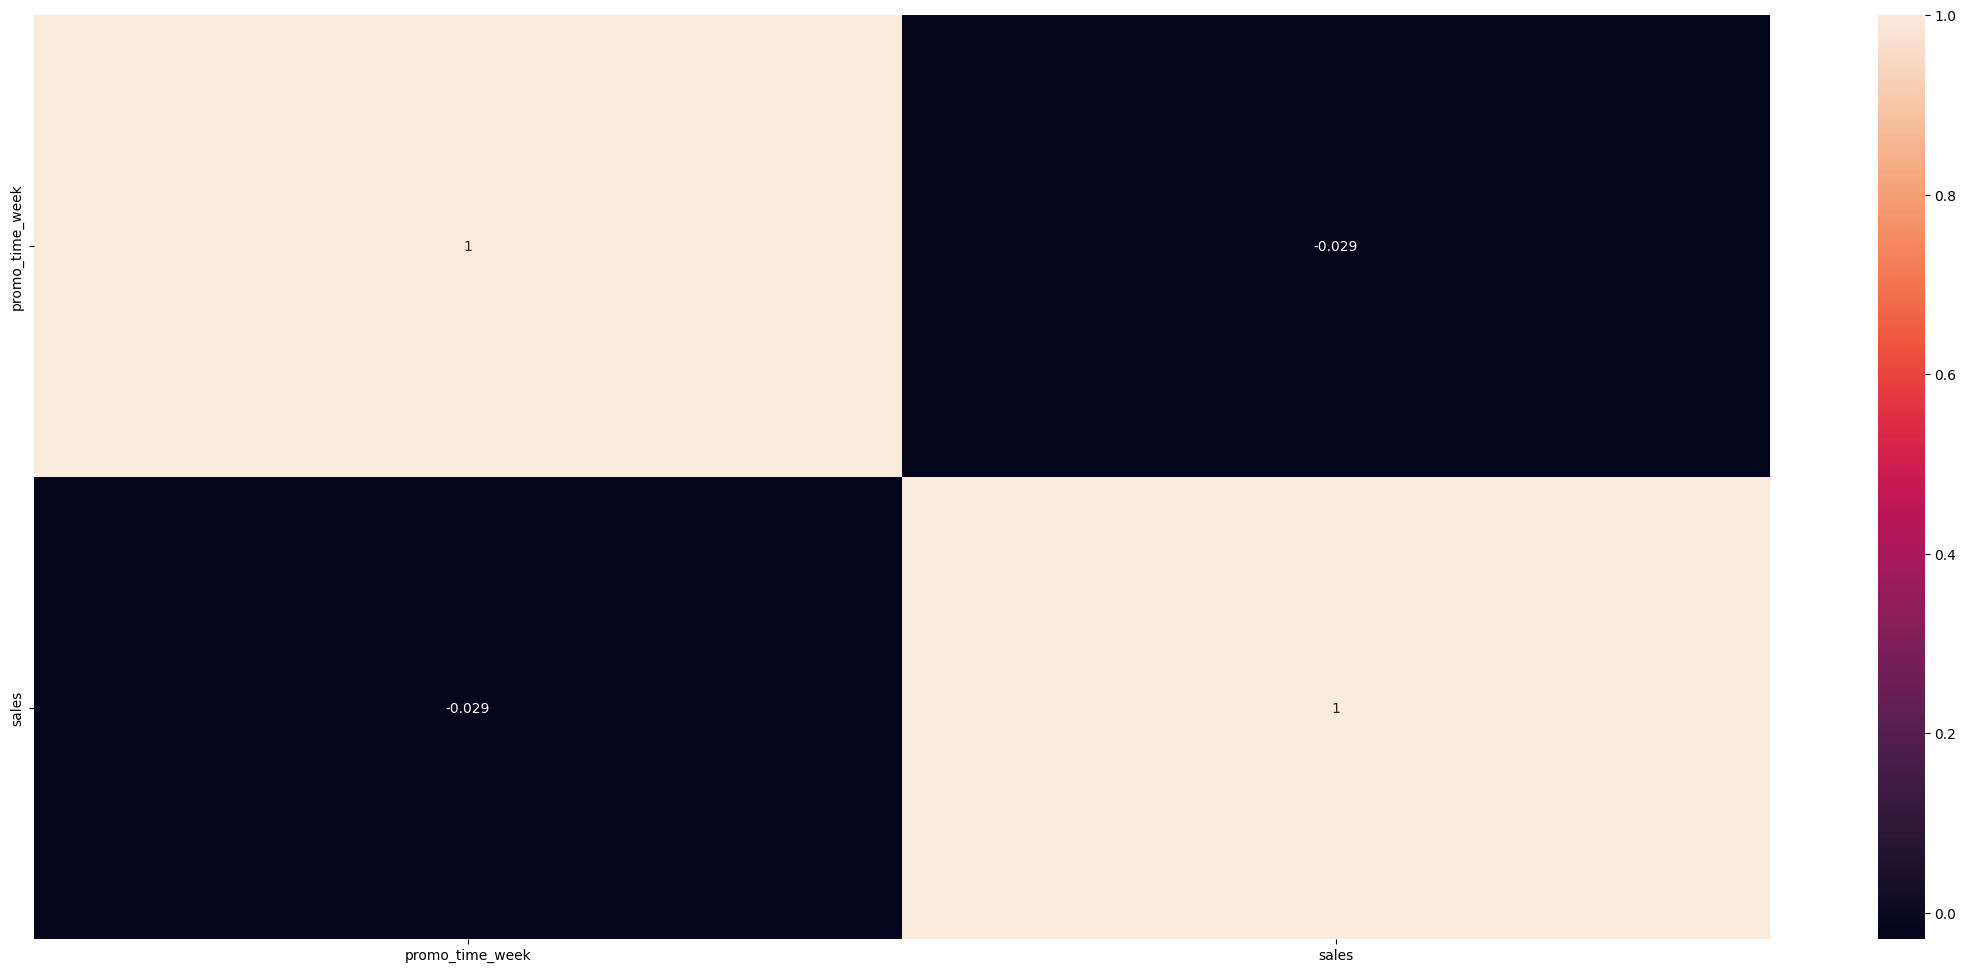

In [53]:
plt.figure(figsize=(28, 12))
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H5 Lojas com mais dias de promoção deveriam vender mais (Faremos uma segunda analise mais para frente)

### H6 Lojas com mais promoções consecutivas deveriam vender mais
#### **FALSA** Lojas com promocoes consecutivas vendem menos

In [54]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

# Veja que neste quadro as lojas que participaram somente da promo e não participaram da promo2 se sairam melhores em vendas

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


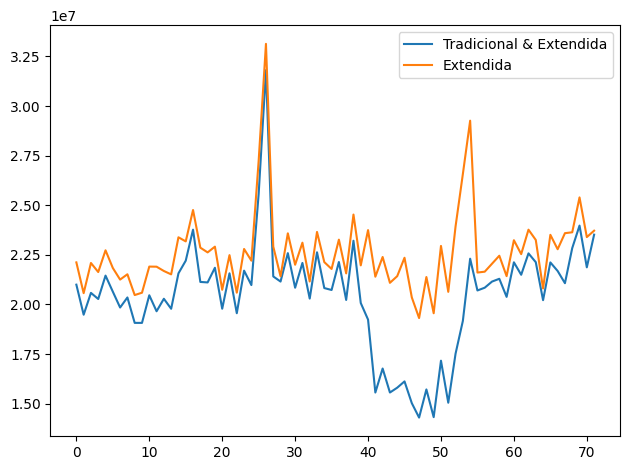

In [55]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
aux2.plot(ax = ax)
ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

# Ajuste o layout para evitar sobreposição de rótulos
plt.tight_layout()

# Exiba a figura
plt.show()

### H8 - Lojas abertas durante o feriado de Natal deveriam vender mais
#### **FALSA** Lojas abertas durante o Natal VENDEM MENOS

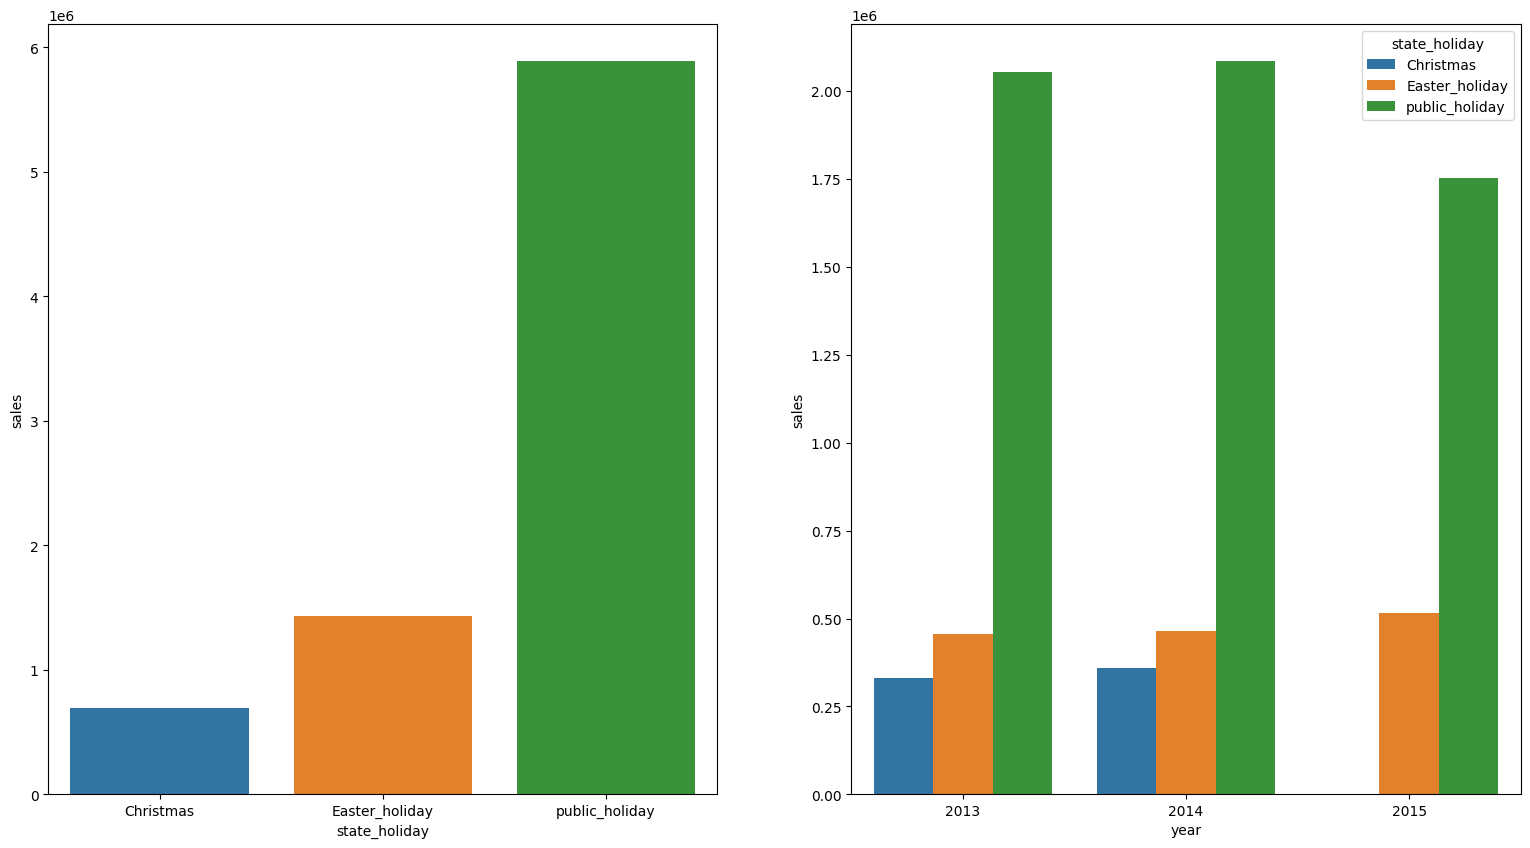

In [56]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.figure(figsize=(19, 10))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby(['state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday');

#plt.figure(figsize=(19, 10))
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday');

### H9 - Lojas deveriam vender mais ao longo dos anos
#### **FALSA** Lojas vendem menos ao passar dos anos

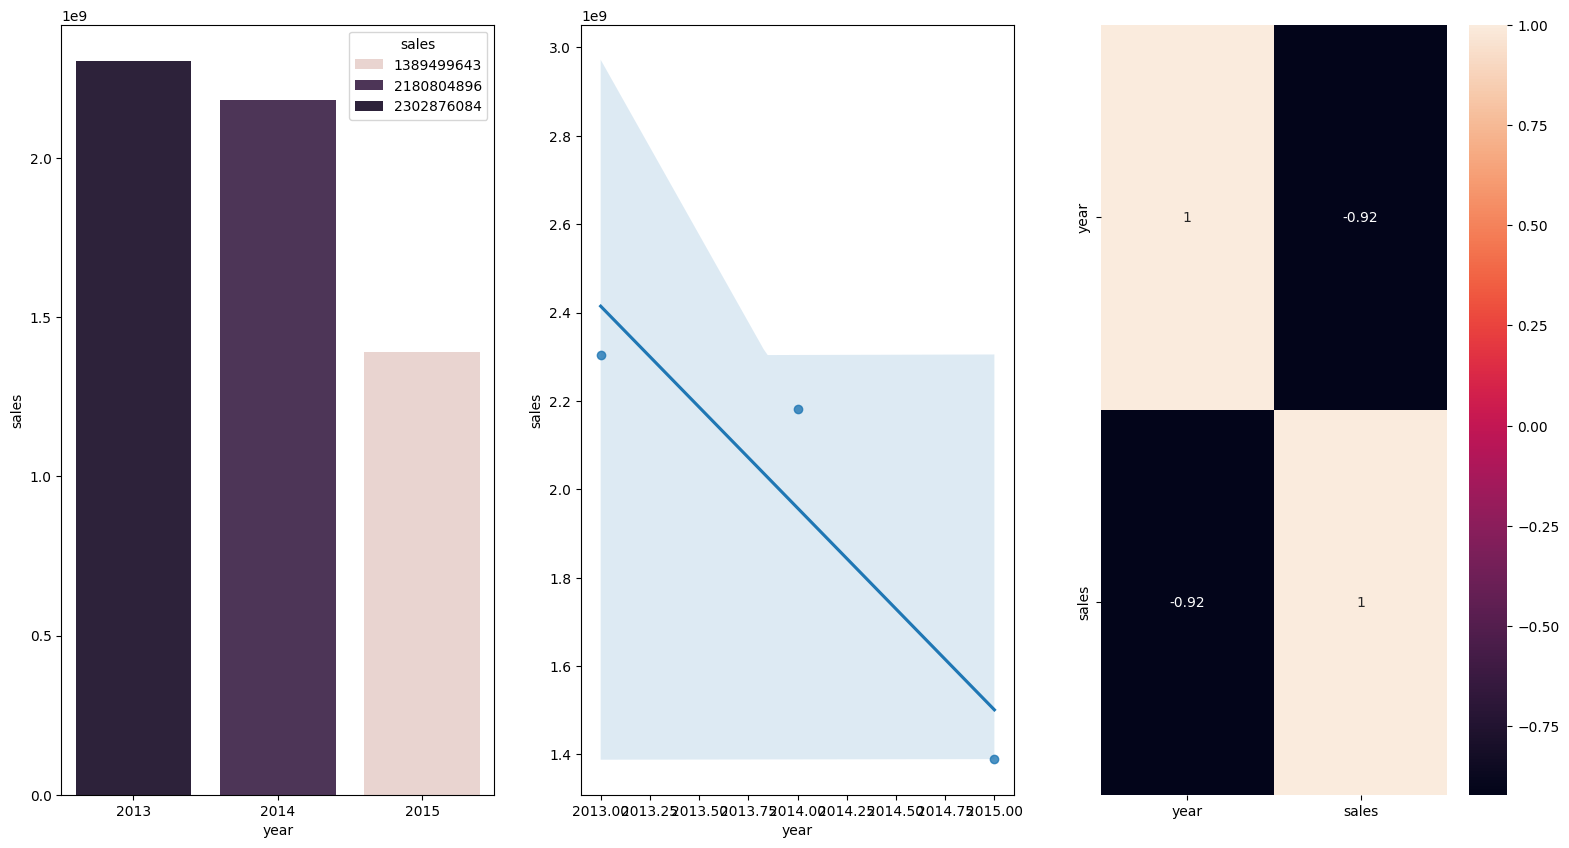

In [57]:
aux1 = df4[['year', 'sales']].groupby(['year']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H10 - Lojas deveriam vender mais no segundo semestre do ano
#### **FALSO** Lojas vendem menoss no 2 semestre do ano

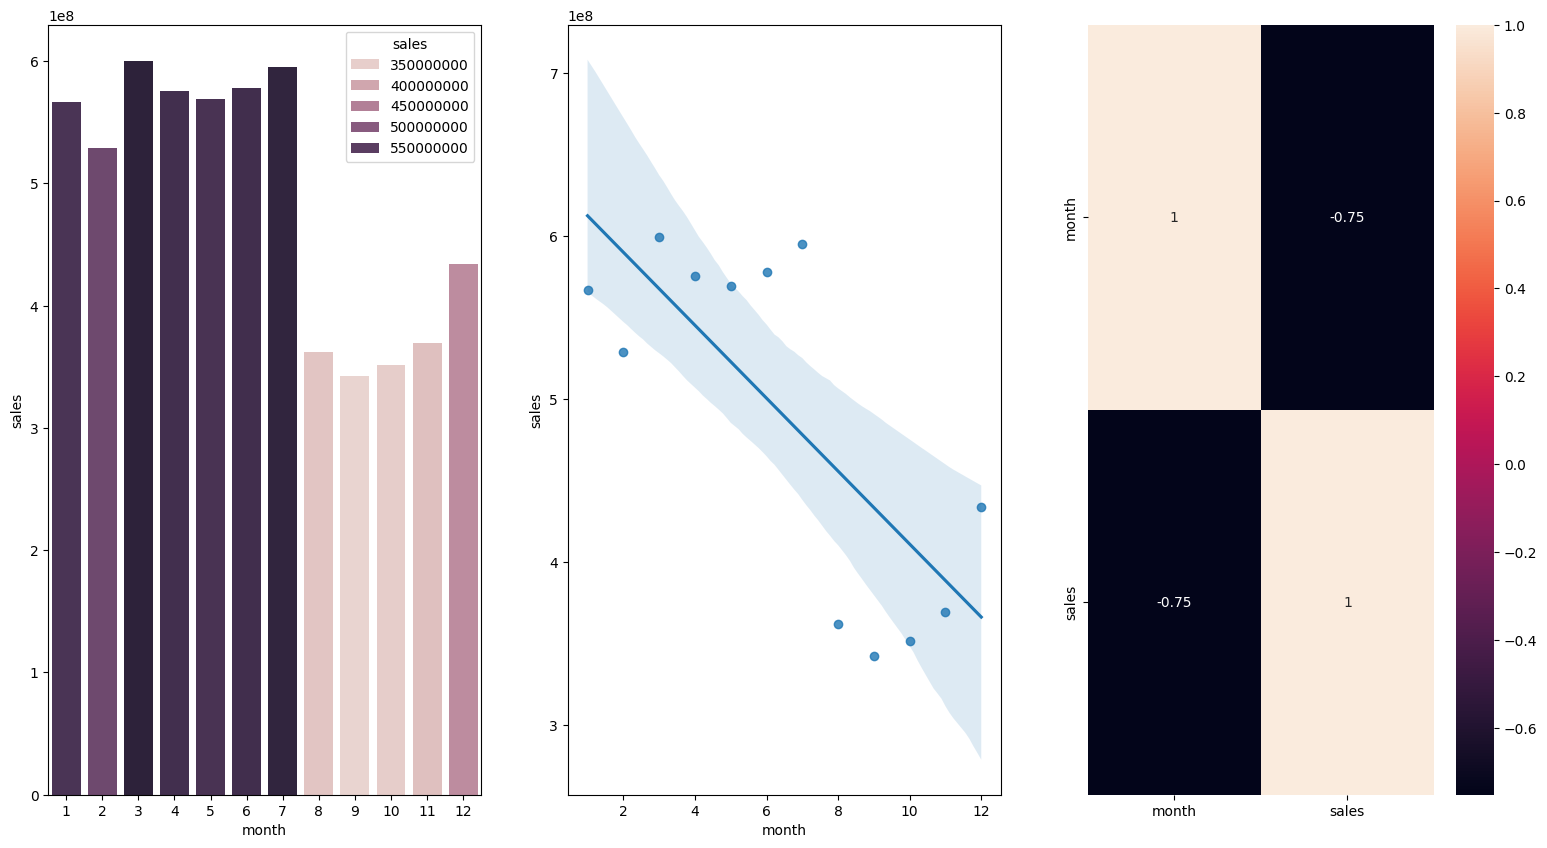

In [58]:
aux1 = df4[['month', 'sales']].groupby(['month']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H11 - Lojas deveriam vender mais depois do dia 10 de cada mês
### **VERDADEIRO** - lojas vendem mais depois do dia 10 de cada mês

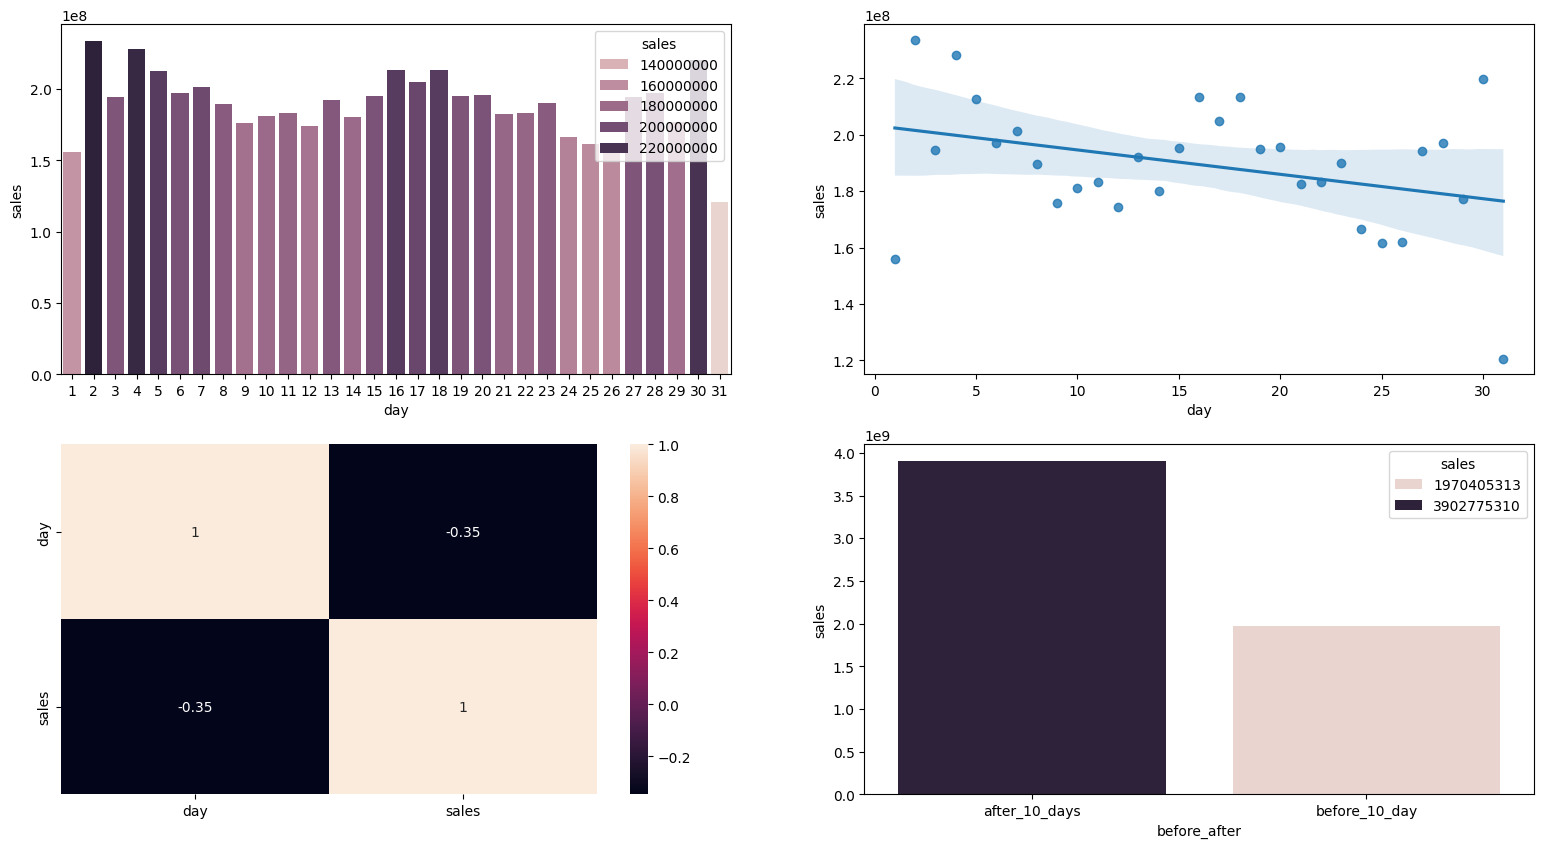

In [59]:
aux1 = df4[['day', 'sales']].groupby(['day']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1, hue='sales');

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby(['before_after']).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2, hue='sales');


### H12 - Lojas deveriam vender menos aos finais de semana
#### **VERDADEIRA** - Lojas vendem menos nos finais de semana

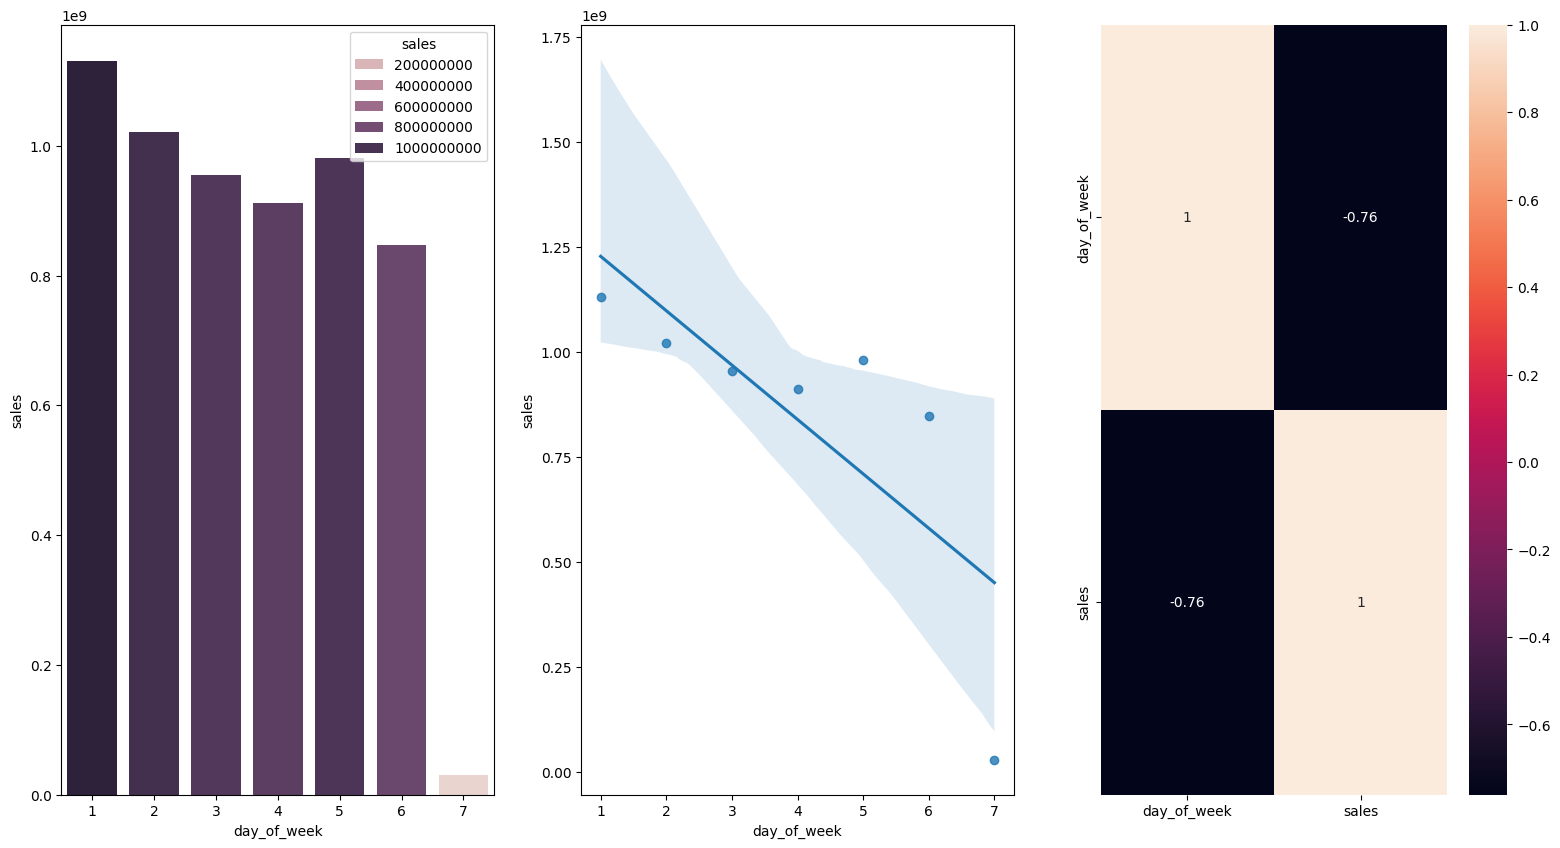

In [60]:
aux1 = df4[['day_of_week', 'sales']].groupby(['day_of_week']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1, hue='sales');

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr (method='pearson'), annot=True);

### H13 - Lojas deveriam vender menos durante os feriados escolares
#### **VERDADEIRA** - Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

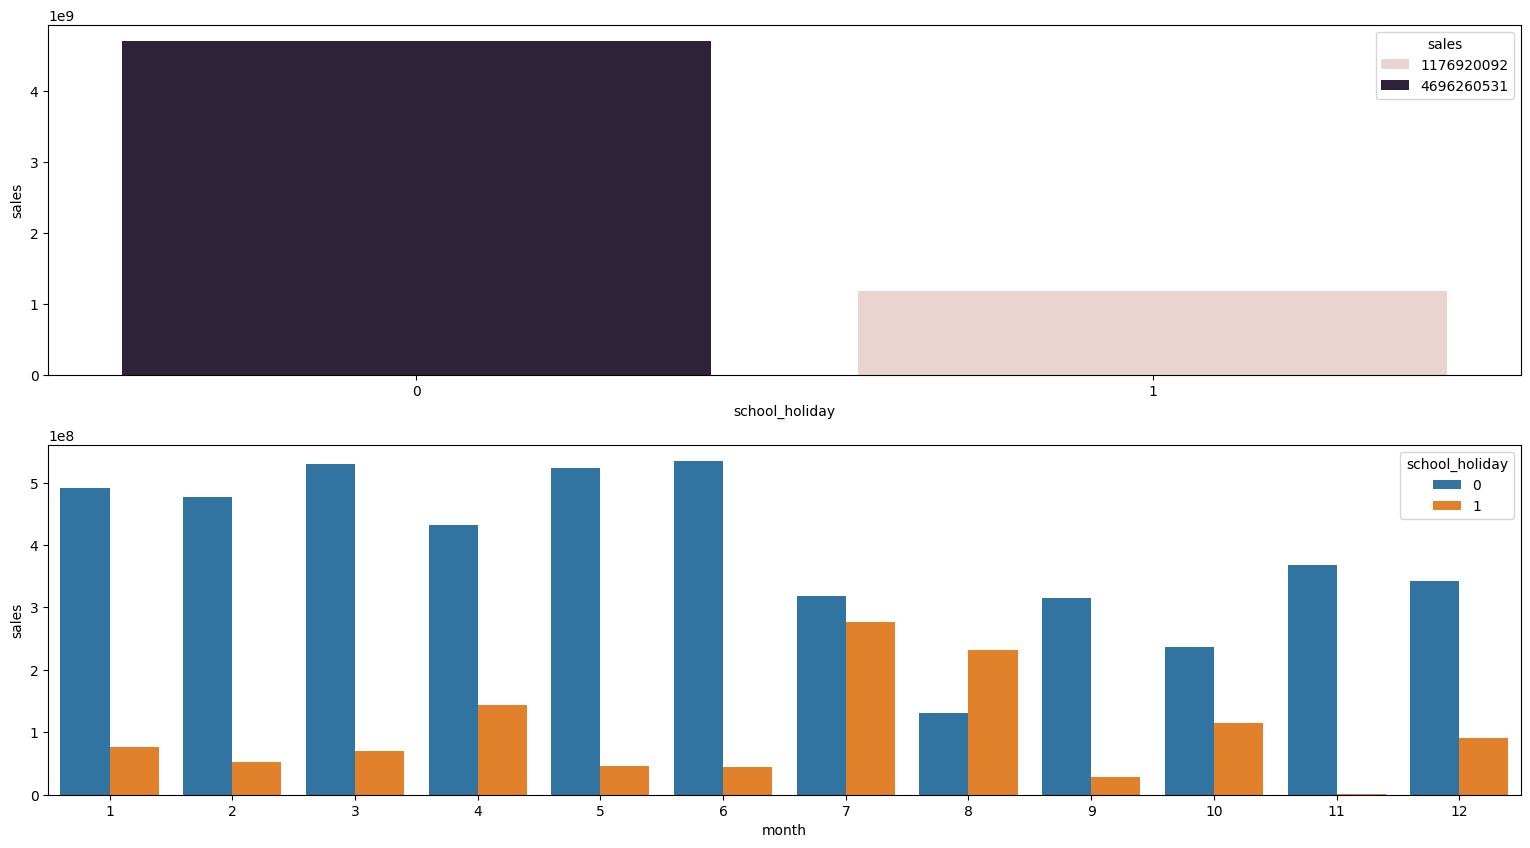

In [61]:
aux1 = df4[['school_holiday', 'sales']].groupby(['school_holiday']).sum().reset_index()


plt.figure(figsize=(19, 10))
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1, hue='sales');

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday');

### 4.2.1 Resumo das Hipoteses

In [62]:
from tabulate import tabulate

tab = [['Hipoteses', 'Conclusao', 'Relevancia' ],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Media'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Alta'],
       ['H13', 'Verdadeira', 'Baixa'],
       ]
print(tabulate(tab, headers='firsthow'))


f          i           r
---------  ----------  ----------
Hipoteses  Conclusao   Relevancia
H1         Falsa       Baixa
H2         Falsa       Media
H3         Falsa       Media
H4         Falsa       Baixa
H5         -           -
H7         Falsa       Baixa
H8         Falsa       Media
H9         Falsa       Alta
H10        Falsa       Alta
H11        Verdadeira  Alta
H12        Verdadeira  Alta
H13        Verdadeira  Baixa


## 4.3 Analise Multivariada

#### 4.3.1 Atributos Numericos

In [63]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


<Axes: >

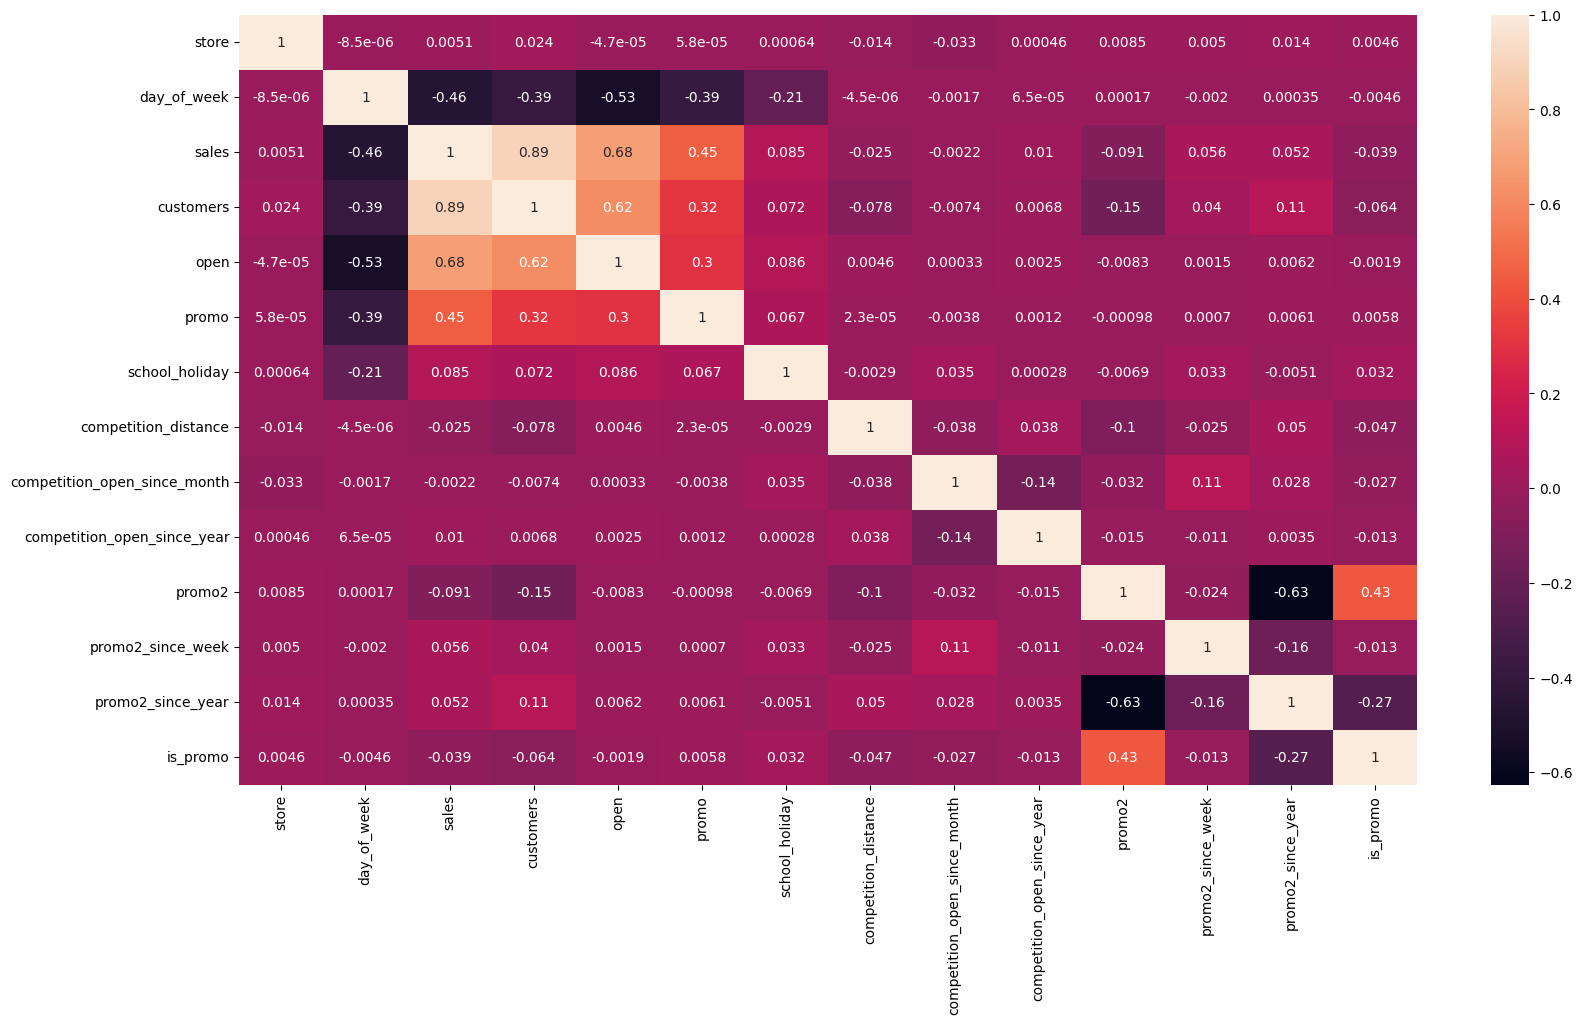

In [64]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(19, 10))
sns.heatmap(correlation, annot=True)

#### 4.3.2 Variaveis Categoricas

In [65]:
cm = pd.crosstab(a['state_holiday'], a ['store_type']).to_numpy()
chi2 = stats.chi2_contingency(cm)

In [66]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr / n) / (min(kcorr-1, rcorr-1 )))

In [67]:
a = df4.select_dtypes(include='object')

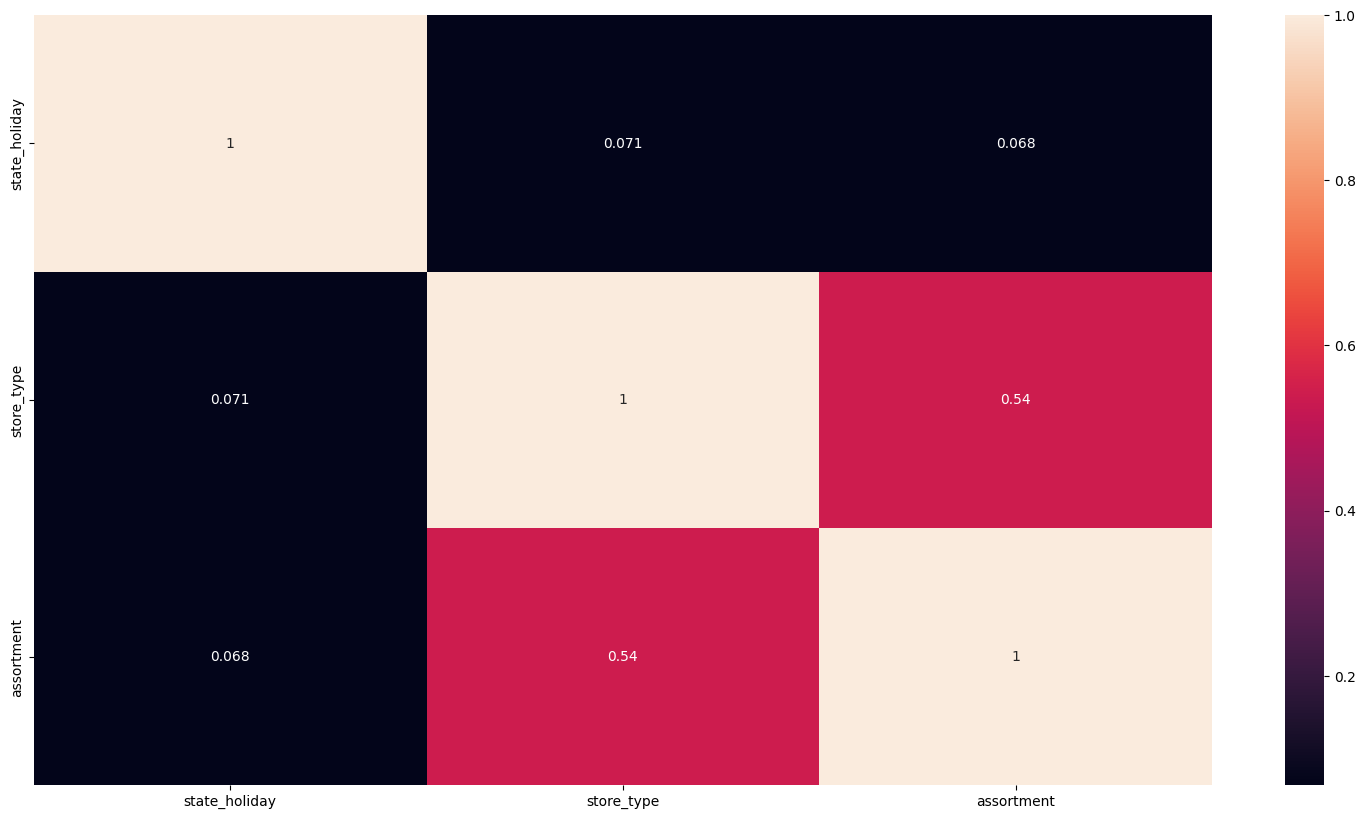

In [68]:
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

plt.figure(figsize=(19, 10))
sns.heatmap(d, annot=True);

# 5.0 Passo 5 - Preparacao dos Dados

In [69]:
df5 = df4.copy()

## 5.1 - Normalizacao

## 5.2 - Rescaling

In [70]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# year
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# competition time month
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# promo week
df5['year'] = mms.fit_transform(df5[['year']].values)



C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\4082983635.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




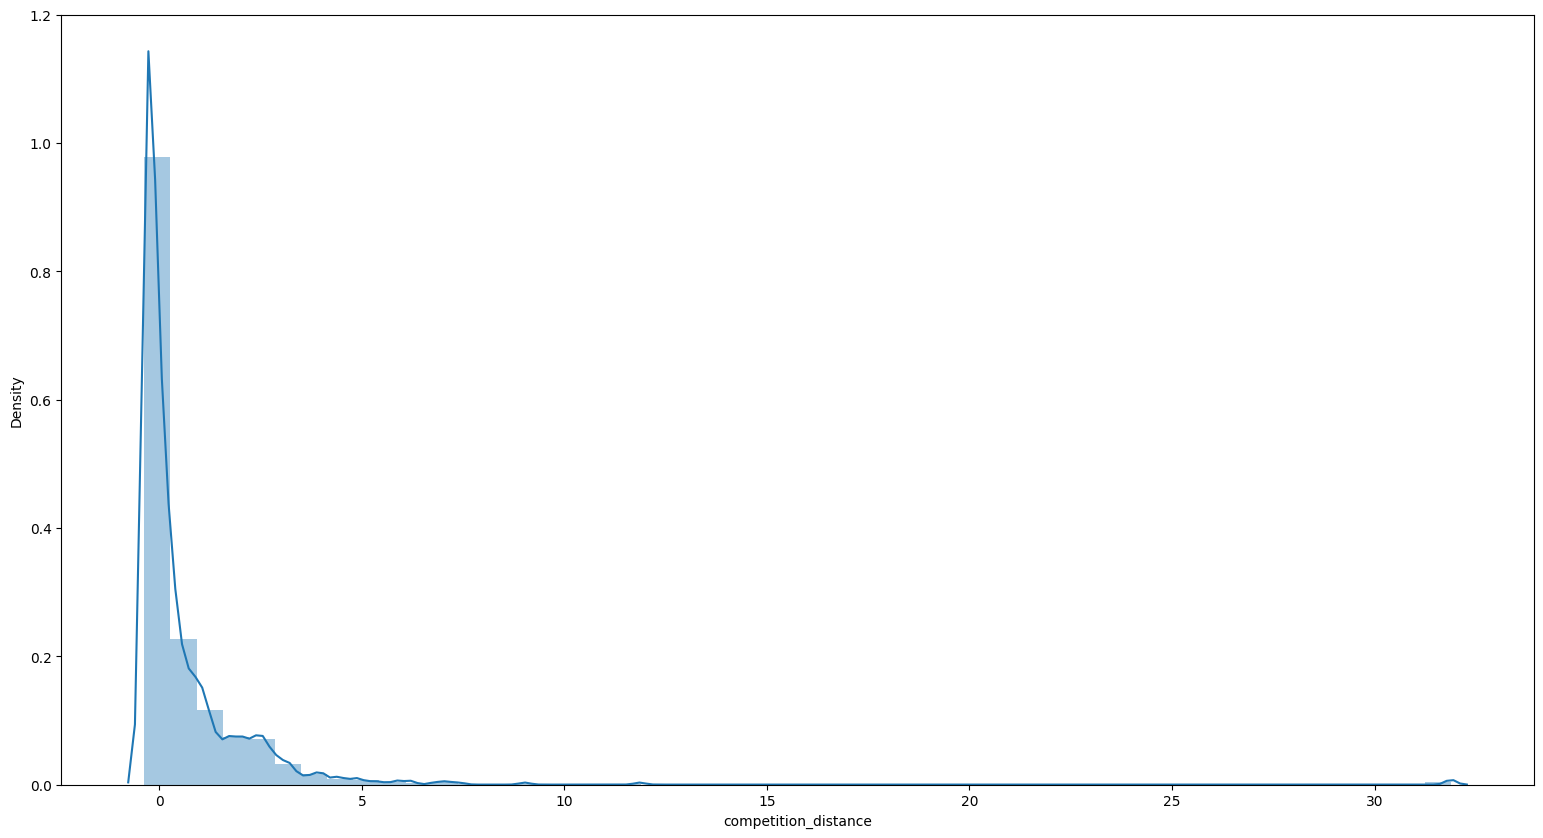

In [71]:
plt.figure(figsize=(19, 10))
sns.distplot(df5['competition_distance']);

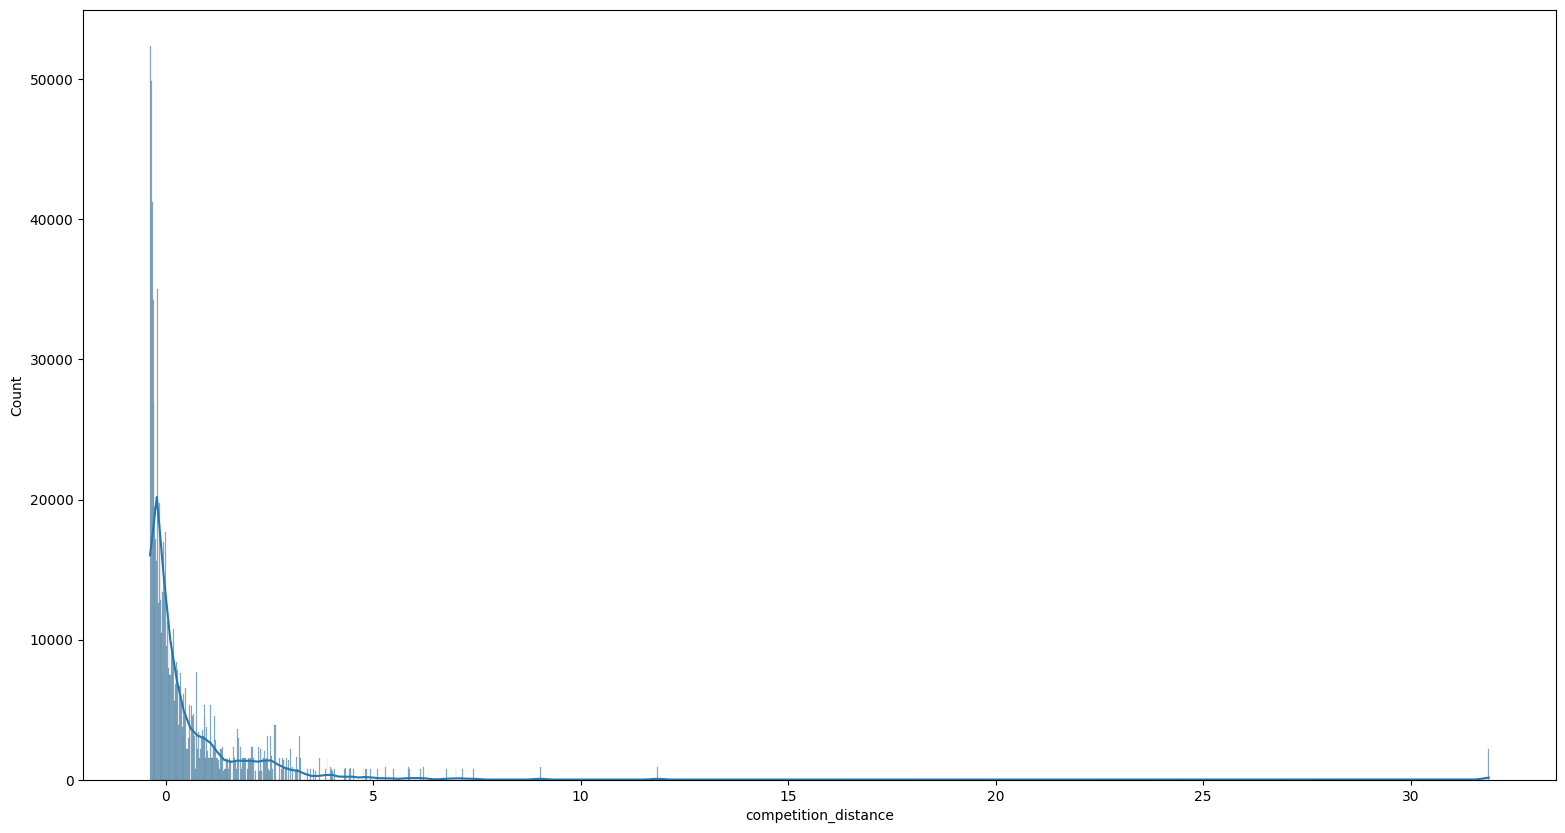

In [72]:
plt.figure(figsize=(19, 10))
sns.histplot(df5['competition_distance'], kde=True)  # Use kde=True para adicionar uma estimativa de densidade de kernel (opcional)
plt.show()

## 5.3 - Transformacao

### 5.3.1 - Encoding

In [73]:
# state_holiday - One Hot Encoding

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding

assortment_dict = {'basic':1 , 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.1 - Response Variable Transformation

C:\Users\jcmaz\AppData\Local\Temp\ipykernel_18468\1713290504.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




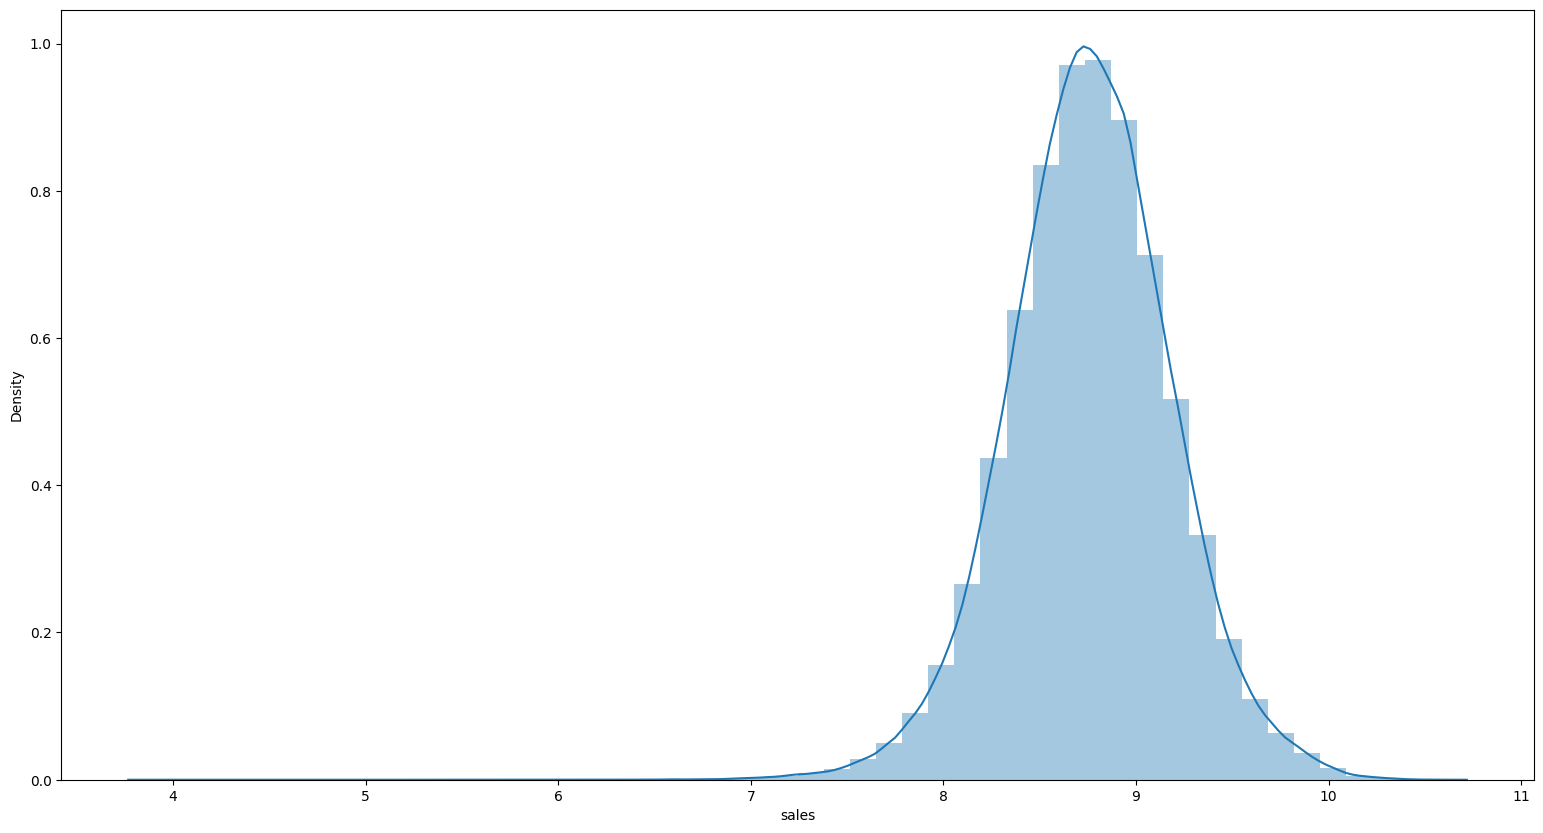

In [74]:
df5['sales'] = np.log1p(df5['sales'])
plt.figure(figsize=(19, 10))
sns.distplot(df5['sales'],kde=True);

### 5.3.3 - Transformacao de Natureza

In [75]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [76]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.464723,-0.885456


# 6.0 - FEATURE SELECTION

In [77]:
df6 = df5.copy()

## 6.1 - Split Dataframe em Treino e Teste

In [78]:
# Aqui é um passo muito importante onde iremos descartar todas as variaveis que não importam mais

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

# Apagando as colunas que não importam mais e setando o axis=1 para limpar todo o conteudo das linhas tambem
df6 = df6.drop(cols_drop, axis=1)

In [79]:
# Neste passo estou pegando a coluna date e subitraindo 6 semanas que são exatamente 42 dias evidenciado no datetime

df6[['store', 'date']].groupby(['store']).max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [80]:
# Dados de Treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Dados de Teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Min Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Min Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [81]:
#================= Metodo Boruta utilizado para treinar o algoritmo para descobrir qual melhor variavel ou seja as mais relevantes (coluna do dataset a ser utilizado)

# DESTRAVE SOMENTE SE QUISER ACHAR MAIS VARIAVEIS PARA TREINAR

# Training and test dataset for
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# Define RamdonForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 - Best Features from Boruta

In [82]:
#cols_selected = boruta.support_.tolist()

# Best Features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Não selecionadas pelo boruta - Aqui serão as colunas que o boruta não selecionou como relevante
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


## 6.3 Manual Feature Selection

In [83]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features, adicionar os elementos no final da lista
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [84]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [85]:
# Essa variavel foi comentada pois utiliza a machine learning boruta e para não ficar 48 min processando prefiro desabilitar

#cols_not_selected_boruta

# 7.0 Machine Learning Modelling

In [86]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]


## 7.1 Average Model

In [87]:
#def mean_percentage_error( y, yhat ):
#    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs( (y - yhat) /y ))

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )

    return pd.DataFrame( { 'Model Name': model_name,
                                'MAE': mae,
                                'MAPE': mape,
                                'RMSE': rmse }, index=[0] )


In [88]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby(['store']).mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

# Estimativa do valor real
yhat_baseline = aux1['predictions']

# Performance
# Como a variavel y_test fizemos o log1p temos que voltar a variavel para padrão, e nisso fazemos utilizando a exponenciação 
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [89]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.271764,0.292644,2671.58153


### 7.2.1 Linear Regression Model - Cross Validation

In [90]:
# LR Result de cross validation
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.69 + / - 295.46,0.3 + / - 0.02,2952.4 + / - 468.14


## 7.3 Linear Regression Regularized Model - LASSO

In [91]:
# model - Lembre se quanto mais aumento as casas decimais de alpha=0.001 maior vai ser o RMSE
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [92]:
# LR Result de cross validation
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.64 + / - 341.56,0.29 + / - 0.01,3057.92 + / - 504.71


## 7.4 Random Forest Regressor

In [93]:
rf = RandomForestRegressor (n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error( 'Random Forrest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forrest Regressor,666.598232,0.097462,994.937223


### 7.4.1 Random Forester Regressor - Cross Validation

In [94]:
# LR Result de cross validation
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,841.46 + / - 221.64,0.12 + / - 0.02,1264.3 + / - 325.71


## 7.5 XGBoost Regressor

In [95]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=600,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              #tree_method='gpu_hist',  # Use 'gpu_hist' para treinamento com GPU
                              #gpu_id=0,  # ID da GPU que você deseja usar
                              colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1030.950365,0.14932,1521.336977


### 7.5.1 XGBost - Cross Validation

In [96]:
# XGB Result de cross validation, alterando o numero depois da varialvel x_training que no caso padrao é 5 você pode melhorar a performance da ML

xgb_result_cv = cross_validation( x_training, 5, 'XGBost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBost Regressor,1202.02 + / - 188.65,0.16 + / - 0.01,1738.42 + / - 265.69


## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [97]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forrest Regressor,666.598232,0.097462,994.937223
0,XGBoost Regressor,1030.950365,0.149320,1521.336977
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.271764,0.292644,2671.581530
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performance - Cross Validation

In [98]:
x_training = X_train[cols_selected_boruta_full]

In [99]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

# com 10 deu 1616
# com 6 deu 1673
# com 5 deu 1738

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.69 + / - 295.46,0.3 + / - 0.02,2952.4 + / - 468.14
0,Lasso,2116.64 + / - 341.56,0.29 + / - 0.01,3057.92 + / - 504.71
0,Random Forest Regressor,841.46 + / - 221.64,0.12 + / - 0.02,1264.3 + / - 325.71
0,XGBost Regressor,1202.02 + / - 188.65,0.16 + / - 0.01,1738.42 + / - 265.69


In [100]:
model = Lasso(alpha=0.01)
a = cross_validation( x_training, 5, 'Lasso', model, verbose=True)
a


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.64 + / - 341.56,0.29 + / - 0.01,3057.92 + / - 504.71


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [101]:
import random
import warnings
warnings.filterwarnings('ignore')

In [102]:
# ATENCAO ESTOU TRAVANDO ESSE SNIPET POIS SERVE APENAS PARA DEFINIR QUAL É O MELHOR PARAMETRO

# PARA ATIVAR RETIRE #

#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weigth': [3, 8, 15]
#       }
#MAX_EVAL = 10

In [103]:
# ATENCAO ESTOU TRAVANDO ESSE SNIPET POIS SERVE APENAS PARA DEFINIR QUAL É O MELHOR PARAMETRO

# PARA ATIVAR RETIRE #

#final_result = pd.DataFrame()

#for i in range (MAX_EVAL):
    
    # Escolhendo os valores dos parametros randomicamente
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)

#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weigth=hp['min_child_weigth'])

    # performance
#    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#final_result

## ------------------------------------------------------------------------------------------------------------

## 8.2 Final Model

In [104]:
#n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weigth': 8
#0	XGBoost Regressor	864.67 + / - 72.05	0.12 + / - 0.01	1250.44 + / - 152.28
param_tuned = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'min_child_weigth': 8
       }

In [105]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weigth=param_tuned['min_child_weigth']).fit(x_train, y_train)
# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

# XGBoost Regressor	1557.905577	0.235926	2257.318907

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,659.24646,0.095069,961.894968


In [123]:
# EntAo no caso o MAE é a diferença do meu preço medio que pode ser no caso de 569 reais o minimo e o maximo de 40981

# No caso esta EXCELENTE sendo queo meu minimo é de 569 e eu consegui uma variancia de 659 o valor no do MODELO esta bem

valor_min = np.expm1( y_test ).min()

valor_max = np.expm1( y_test ).max()

valor_final = np.expm1( y_test ).max() - np.expm1( y_test ).min()

print('O valor minimo é: {} e o maximo é {}'.format(valor_min, valor_max))
print('A Diferennça do minimo e maximo é de: {}'.format(valor_final))

print('\nEntão o meu valor do MAE sendo 659 é excelente')

O valor minimo é: 569.0000000000002 e o maximo é 41550.99999999998
A Diferennça do minimo e maximo é de: 40981.99999999998

Então o meu valor do MAE sendo 659 é excelente


569.0000000000002

In [107]:
# Calculando a média 

#     Model Name	    MAE	        MAPE	    RMSE
#     XGBoost Regressor	659.24646	0.095069	961.894968
media = np.expm1( y_test ).mean()
print('A media é {}'.format(media))

mae = (659 / media)
mae = (mae * 100)

print('\nO percentual de erro é de {}%'.format(mae))

# Aqui estou calculando o percentual do erro do MAPE sendo que esta

A media é 6995.162576094309

O percentual de erro é de 9.420796054863777%


In [115]:
# Agora no caso de ser mais rigido consideramos o RMSE

# Atribui o maior peso para os outliers, sensivel na presenca de outliers 

# Ideal para medir performance de modelos de ML ( machine learning )  
rmse = 961
rmse = ((rmse/media)*100)
print('O percentual do ERRO do RMSE é {} %'.format(rmse))

O percentual do ERRO do RMSE é 13.738065263617738 %


In [133]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.005073362919104086

# 9.0 Traducao e Interpretação do ERRO

In [136]:
df9 = X_test[cols_selected_boruta_full]

# Rescaale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [174]:
# sum of prediction 
df91 = df9[['store', 'predictions']].groupby(['store']).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby(['store']).apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby(['store']).apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [175]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104628.890625,101365.176629,107892.604621,3263.713996,0.547606
908,909,239815.703125,232327.491423,247303.914827,7488.211702,0.505485
875,876,205831.359375,201927.006592,209735.712158,3904.352783,0.301299
549,550,237614.671875,236386.967378,238842.376372,1227.704497,0.246677
1038,1039,358633.625000,356743.634251,360523.615749,1889.990749,0.245222


<Axes: xlabel='store', ylabel='MAPE'>

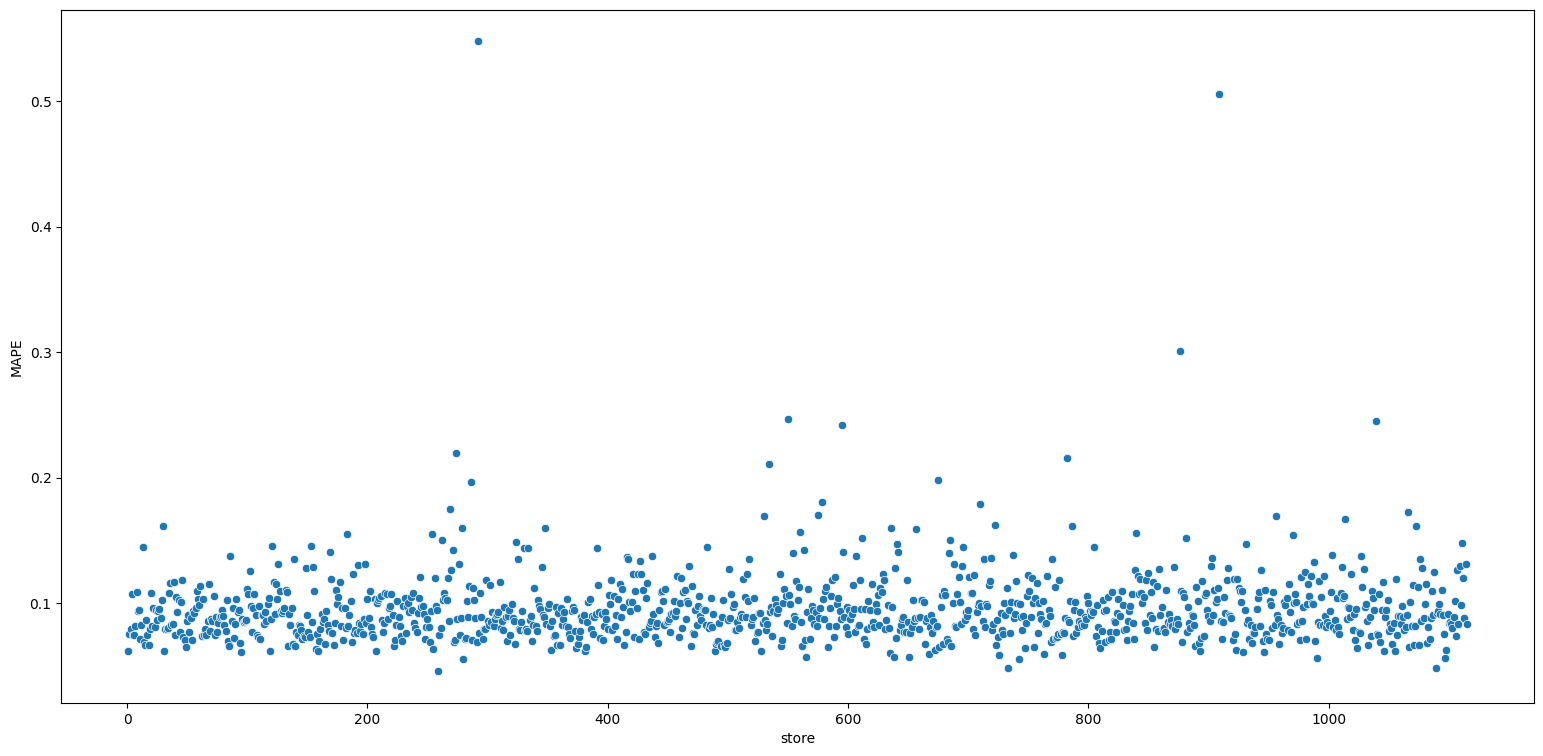

In [176]:
plt.figure(figsize=(19, 9))
sns.scatterplot(x='store', y='MAPE', data=df92)

In [177]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
832,833,199494.90625,199048.135353,199941.677147,446.770897,0.085857
70,71,340612.56250,339879.087693,341346.037307,733.474807,0.086121
1113,1114,734009.81250,730981.642868,737037.982132,3028.169632,0.131001
413,414,246952.59375,246492.416992,247412.770508,460.176758,0.066636
559,560,454687.81250,452360.023992,457015.601008,2327.788508,0.156457


## 9.2 Total Performance

In [181]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum( x ),axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 282,981,056.00"
1,worst_scenario,"R$ 282,242,236.56"
2,best_scenario,"R$ 283,719,827.08"


## 9.3 Machine Learning Performance

In [195]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

AttributeError: Line2D.set() got an unexpected keyword argument 'linestyles'

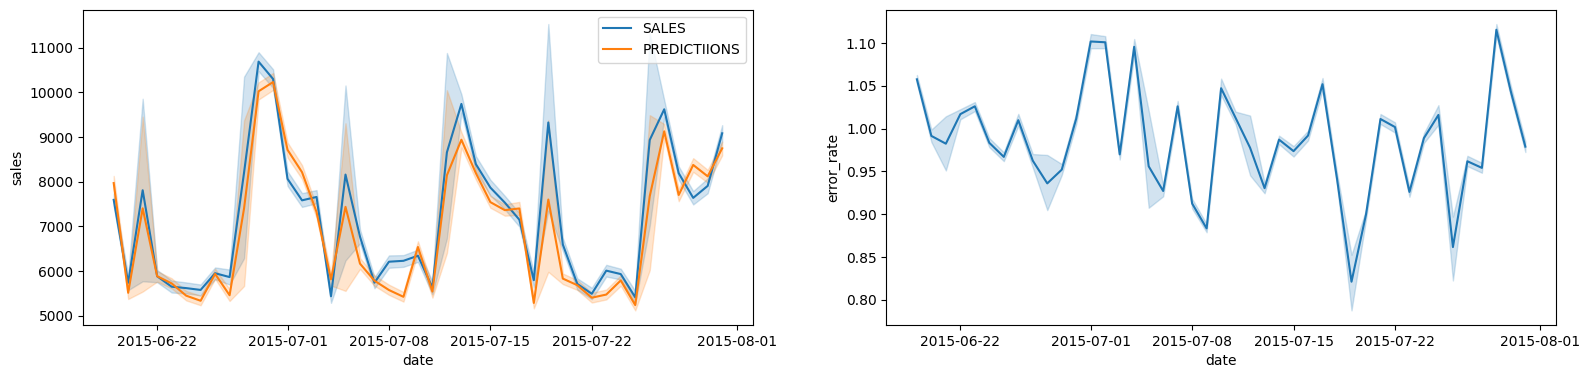

In [202]:
plt.figure(figsize=(19, 9))

plt.subplot( 2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIIONS')

plt.subplot( 2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3)
sns.distplot(df9['error'])

plt.subplot( 2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

In [134]:
import pickle

In [135]:
#pickle.dump(model_xgb_tuned, open('C:/Users/jcmaz/Downloads/Python/Rossmann/data/model_rossmann.pkl', 'wb'))